In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import plotly.io as pio

from rdkit import Chem
from rdkit.Chem import PandasTools, AllChem, Descriptors
from rdkit import DataStructs
import plotly.express as px
import cirpy

import molplotly 

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import sqlite3
import sqlalchemy 

pio.renderers
pio.renderers.default = "notebook_connected"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
con = sqlite3.connect('smiles_cas_pv.db')
cur = con.cursor()

In [3]:
raw_data = pd.read_sql_query("SELECT DISTINCT A.CAS,A.Name, max(A.Primary_Odor) as odor, B.smiles,C.pv from odor AS A LEFT JOIN name_cas_smiles as B on A.CAS=B.CAS INNER JOIN vp as C on B.smiles=C.smiles GROUP by A.CAS, A.Name ORDER by pv", con)
raw_data['Name'] = raw_data['Name'].replace({'"':''}, regex=True)
print(raw_data.shape)
raw_data.tail()

(638, 5)


,CAS,Name,odor,smiles,pv
633,78-84-2,Isobutyraldehyde,Sweet,CC(C)C=O,164.0
634,78-84-2,isobutyraldehyde,aldehidico,CC(C)C=O,164.0
635,123-38-6,Propionaldehyde,Woody,CCC=O,317.0
636,75-07-0,Acetaldehyde,Woody,CC=O,910.0
637,124-40-3,Dimethylamine,Sickening,CNC,1470.0


In [4]:
## drop names duplicados 
#data[data['Name'].duplicated()]
raw_data = raw_data.drop_duplicates(['Name']).reset_index(drop=True)
raw_data = raw_data[raw_data['pv']<10].reset_index(drop=True)
print(raw_data.shape)
raw_data.tail()

(598, 5)


,CAS,Name,odor,smiles,pv
593,584-02-1,3-Pentanol,Woody,CCC(O)CC,8.57
594,693-95-8,4-Methylthiazole,Vegetables,Cc1cscn1,8.62
595,66-25-1,Hexanal,Woody,CCCCCC=O,9.57
596,290-37-9,Pyrazine,Sweet,c1cnccn1,9.66
597,107-19-7,Propargyl alcohol,Nature,C#CCO,9.83


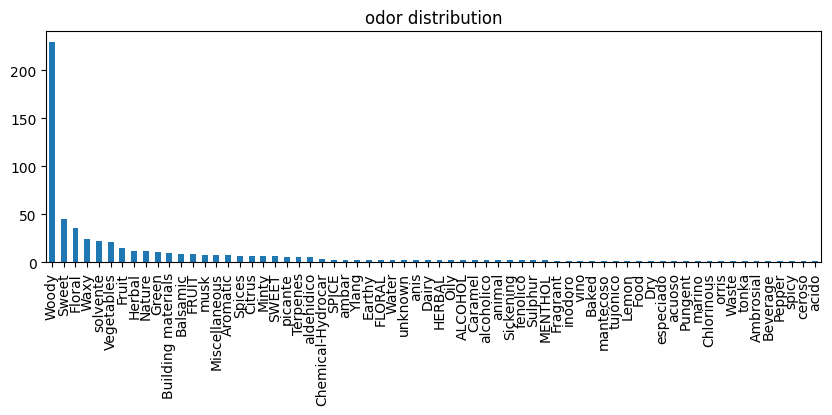

In [5]:
plt.figure(figsize=(10,3))
raw_data['odor'].value_counts().plot(kind='bar')
plt.title('odor distribution')
plt.show()

In [6]:
data_pv_count = raw_data.groupby('odor').agg(count=('odor', 'count'), mean_pv = ('pv', 'mean') ).reset_index(drop=False).sort_values(by='mean_pv', ascending=False)
bar = px.bar(data_frame=data_pv_count, x = 'odor', y = 'mean_pv', color='odor', text_auto=True, text='count',
       template = "simple_white", title = 'odor by mean vapor pressure')
#bar.update_layout(autosize=False,width=1000,height=400)
bar.show()

In [10]:
data_pv_count.head(1)

,odor,count,mean_pv
44,acido,1,8.5


In [6]:
data_pv_count['odor'].value_counts().sum()

66

In [7]:
px.bar(data_frame=data_pv_count.sort_values(['count'], ascending=False), x = 'odor', y = 'count', color='odor', text_auto=True, text='count',
       template = "simple_white", title = 'odor by mean vapor pressure')

In [ ]:
data[data['odor'].isin(['Sweet', 'Floral', 'Waxy'])].reset_index(drop = True)

In [ ]:
freq = data['odor'].value_counts(sort=True).to_frame()
#data['odor'].value_counts(sort=True, normalize=True) 
#freq = freq[freq['odor'] > 2].index.to_list()
#freq=(freq[(freq['odor'] >20) & (freq['odor'] <35)]).index.to_list()

freq=(freq[(freq['odor'] >20) & (freq['odor'] <35)]).index.to_list()
freq = data[data['odor'].isin(['Sweet', 'Floral', 'Solvente'])]
data_odor = data[data['odor'].isin(freq)].reset_index(drop=True)
data_odor['odor_categorical'] = data_odor['odor'].apply(lambda x: 'S' if x == 'solvente' else('V' if x == 'Vegetables' else 'W'))
print(data_odor.shape)
data_odor.head()

In [9]:
data_odor = raw_data[raw_data['odor'].isin(['Sweet', 'Waxy', 'Woody'])].reset_index(drop = True)
data_odor['odor_categorical'] = data_odor['odor'].apply(lambda x: 'Wo' if x == 'Woody' else('SW' if x == 'Sweet' else 'Wa'))
print(data_odor.shape)
data_odor.head()

(298, 6)


,CAS,Name,odor,smiles,pv,odor_categorical
0,115-95-7,Linalyl acetate,Woody,CC(C)=CCCC(C)(OC(C)=O)C=C,0.000000e+00,Wo
1,142-92-7,Hexyl acetate,Woody,CCCCCCOC(C)=O,0.000000e+00,Wo
2,67634-12-2,Methyl 2-[[[4-(4-hydroxy-4-methylpentyl)-3-,Sweet,COC(=O)c1ccccc1N=CC2CCC(=CC2)CCCC(C)(C)O,7.790000e-10,SW
3,105-95-3,"1,4-Dioxacycloheptadecane-5,17-dione",Woody,O=C1CCCCCCCCCCCC(=O)OCCO1,4.380000e-07,Wo
4,10402-33-2,Eugenyl phenylacetate,Sweet,COc1cc(CC=C)ccc1OC(=O)Cc2ccccc2,2.940000e-06,SW


In [56]:
data_odor.groupby(['odor']).count()

,CAS,Name,smiles,pv,odor_categorical
odor,,,,,
Sweet,45,45,45,45,45
Waxy,24,24,24,24,24
Woody,229,229,229,229,229


In [10]:
freq_odor = data_odor.groupby('odor').agg(count=('odor', 'count'), mean_pv = ('pv', 'mean') ).reset_index(drop=False).sort_values(by='mean_pv', ascending=False)
bar = px.bar(data_frame=freq_odor, x = 'odor', y = 'mean_pv', color='odor', text_auto=True, text='count',
       template = "simple_white", title = 'odor distribution')
bar.update_layout(autosize=False,width=800,height=400)
bar.show()

In [11]:
#data_odor = data_odor.sort_values(by = ['odor_categorical', 'pv'], ascending= True)
bar = px.bar(data_frame=data_odor, x = 'odor', y = 'pv', color = 'odor_categorical', 
             template = "simple_white", title = 'odor distribution')

bar1 = molplotly.add_molecules(fig = bar, df = data_odor,
                              smiles_col='smiles',
                              color_col= 'odor_categorical',
                              caption_cols=['Name'])

bar1.run_server(mode='inline',port=7796) 

In [12]:
carboxylic_acid = Chem.MolFromSmiles('CC(=O)[OH]')
ester = Chem.MolFromSmiles('C[C](=O)OC')
benzene = Chem.MolFromSmarts('c1ccccc1')
eter = Chem.MolFromSmiles('COC')
ketone = Chem.MolFromSmarts('CC(=O)C')
Aldehyde = Chem.MolFromSmiles('C(=O)C')

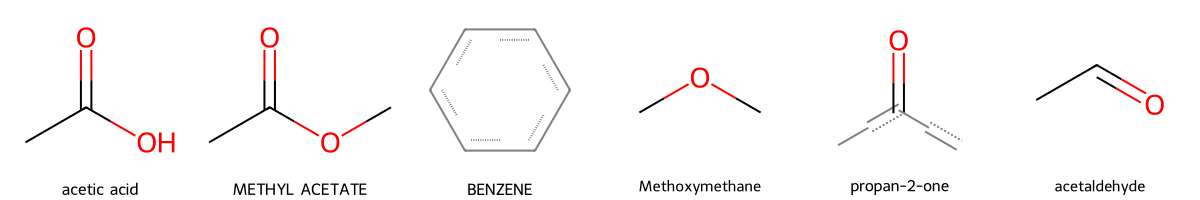

In [13]:
molecular_query = pd.DataFrame([carboxylic_acid,ester,benzene,eter,ketone,Aldehyde]).rename(columns ={0:'molecules'})
molecular_query['smiles'] = molecular_query['molecules'].apply(lambda x: Chem.MolToSmiles(x))
molecular_query['names'] = molecular_query['smiles'].apply(lambda x: cirpy.resolve(x, 'names')[0])
PandasTools.FrameToGridImage(molecular_query, column='molecules', molsPerRow=6,legendsCol='names')

RDKit is a powerful open-source cheminformatics library that provides a wide range of tools for molecular modeling and analysis. Here are some of the most common chemical descriptors that can be calculated using RDKit:

1. Molecular weight
```python
from rdkit import Chem
from rdkit.Chem import Descriptors
mol = Chem.MolFromSmiles('CCO')
mw = Descriptors.MolWt(mol)
print(mw) # 46.07
```

2. LogP (partition coefficient)
```python
from rdkit.Chem import Crippen
logp = Crippen.MolLogP(mol)
print(logp) # -0.77
```

3. Topological polar surface area (TPSA)
```python
from rdkit.Chem import rdMolDescriptors
tpsa = rdMolDescriptors.CalcTPSA(mol)
print(tpsa) # 20.23
```

4. Number of hydrogen bond acceptors
```python
hbda = rdMolDescriptors.CalcNumHBA(mol)
print(hbda) # 1
```

5. Number of hydrogen bond donors
```python
hbdd = rdMolDescriptors.CalcNumHBD(mol)
print(hbdd) # 1
```

6. Number of rotatable bonds
```python
rotb = Descriptors.NumRotatableBonds(mol)
print(rotb) # 1
```

7. Number of heavy atoms
```python
heavy_atoms = Descriptors.HeavyAtomCount(mol)
print(heavy_atoms) # 3
```

8. Number of rings
```python
rings = Descriptors.RingCount(mol)
print(rings) # 0
```

These are just a few examples of the many chemical descriptors that can be calculated using RDKit. RDKit also provides many other descriptors, such as charge, dipole moment, and many others.

In [14]:
data_odor['MolMR'] = data_odor['smiles'].apply(lambda x: Chem.MolFromSmiles(x)).apply(lambda x: Descriptors.MolMR(x))
data_odor['MW'] = data_odor['smiles'].apply(lambda x: Chem.MolFromSmiles(x)).apply(lambda x: Descriptors.ExactMolWt(x))
data_odor['MolLogP'] = data_odor['smiles'].apply(lambda x: Chem.MolFromSmiles(x)).apply(lambda x: Chem.Crippen.MolLogP(x))
data_odor['TPSA'] = data_odor['smiles'].apply(lambda x: Chem.MolFromSmiles(x)).apply(lambda x: Chem.rdMolDescriptors.CalcTPSA(x))## Topological polar surface area (TPSA)
data_odor['CSP3'] = data_odor['smiles'].apply(lambda x: Chem.MolFromSmiles(x)).apply(lambda x: Descriptors.FractionCSP3(x))## Fraction of heavy atoms that are aromatic

Partial_charges = []
san = data_odor['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
#------
for i in san:
    AllChem.ComputeGasteigerCharges(i)
for j in san:
    value = j.GetAtomWithIdx(0).GetDoubleProp('_GasteigerCharge')
    Partial_charges.append(value)
data_odor['Part_charg'] = Partial_charges
#------
data_odor["n_Atoms"] = data_odor['smiles'].apply(lambda x: Chem.MolFromSmiles(x)).apply(lambda x: x.GetNumAtoms())
data_odor['n_car_acid'] = data_odor['smiles'].apply(lambda x: Chem.MolFromSmiles(x)).apply(lambda x: len(x.GetSubstructMatches(carboxylic_acid)))
data_odor['n_ester'] = data_odor['smiles'].apply(lambda x: Chem.MolFromSmiles(x)).apply(lambda x: len(x.GetSubstructMatches(ester)))
data_odor['n_benzene'] = data_odor['smiles'].apply(lambda x: Chem.MolFromSmiles(x)).apply(lambda x: len(x.GetSubstructMatches(benzene)))
data_odor['n_eter'] = data_odor['smiles'].apply(lambda x: Chem.MolFromSmiles(x)).apply(lambda x: len(x.GetSubstructMatches(eter)))
data_odor['n_ketone'] = data_odor['smiles'].apply(lambda x: Chem.MolFromSmiles(x)).apply(lambda x: len(x.GetSubstructMatches(ketone)))
data_odor['n_Aldehyde'] = data_odor['smiles'].apply(lambda x: Chem.MolFromSmiles(x)).apply(lambda x: len(x.GetSubstructMatches(Aldehyde)))
raw_dara_odor = data_odor.copy(deep=True)
#data_odor = data_odor.drop('odor_categorical', axis=1)
data_odor.head()

,CAS,Name,odor,smiles,pv,odor_categorical,MolMR,MW,MolLogP,TPSA,CSP3,Part_charg,n_Atoms,n_car_acid,n_ester,n_benzene,n_eter,n_ketone,n_Aldehyde
0,115-95-7,Linalyl acetate,Woody,CC(C)=CCCC(C)(OC(C)=O)C=C,0.000000e+00,Wo,59.0330,196.146330,3.2406,26.30,0.583333,-0.044213,14,1,1,0,1,0,1
1,142-92-7,Hexyl acetate,Woody,CCCCCCOC(C)=O,0.000000e+00,Wo,40.7750,144.115030,2.1298,26.30,0.875000,-0.065382,10,1,1,0,1,0,1
2,67634-12-2,Methyl 2-[[[4-(4-hydroxy-4-methylpentyl)-3-,Sweet,COC(=O)c1ccccc1N=CC2CCC(=CC2)CCCC(C)(C)O,7.790000e-10,SW,101.5063,343.214744,4.8432,58.89,0.523810,0.080954,25,1,1,1,1,0,1
3,105-95-3,"1,4-Dioxacycloheptadecane-5,17-dione",Woody,O=C1CCCCCCCCCCCC(=O)OCCO1,4.380000e-07,Wo,72.7050,270.183109,3.3775,52.60,0.866667,-0.252298,19,2,2,0,2,0,2
4,10402-33-2,Eugenyl phenylacetate,Sweet,COc1cc(CC=C)ccc1OC(=O)Cc2ccccc2,2.940000e-06,SW,82.6760,282.125594,3.5718,35.53,0.166667,0.077718,21,1,1,2,2,0,1


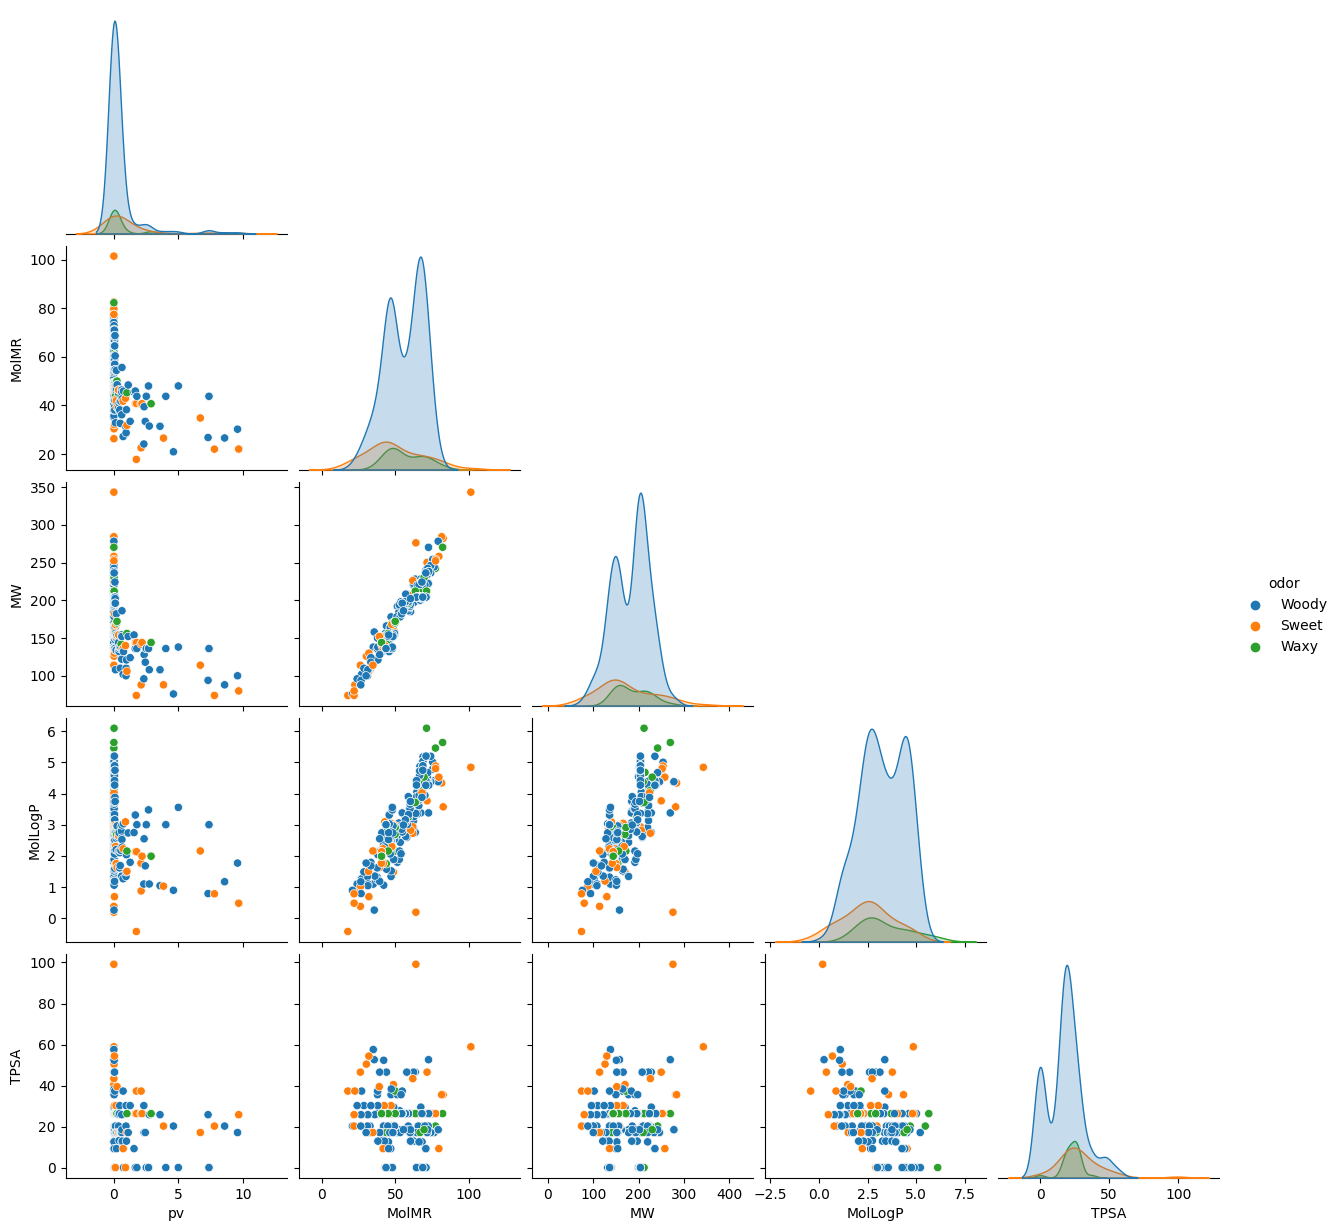

In [19]:
sns.pairplot(data_odor, hue='odor', corner = True)
plt.show()

# Seleccionando caracteristicas mas relevantes mediante PCA

In [20]:
data_odor.head(1)

,CAS,Name,odor,smiles,pv,MolMR,MW,MolLogP,TPSA
0,115-95-7,Linalyl acetate,Woody,CC(C)=CCCC(C)(OC(C)=O)C=C,0.0,59.033,196.14633,3.2406,26.3


In [16]:
X = data_odor.iloc[:,4:].drop('odor_categorical', axis = 1)
y = data_odor['odor']

X_norm = StandardScaler().fit_transform(X)
model_pca = PCA()
model_pca.fit_transform(X_norm)
prop_var = model_pca.explained_variance_ratio_

threshold = 0.06

selected_var = []
for i in range(len(prop_var)):
    if prop_var[i] >= threshold:
        selected_var.append(i)

X_selec = X.iloc[:, selected_var]
X_selec.head()

,pv,MolMR,MW,MolLogP,TPSA
0,0.000000e+00,59.0330,196.146330,3.2406,26.30
1,0.000000e+00,40.7750,144.115030,2.1298,26.30
2,7.790000e-10,101.5063,343.214744,4.8432,58.89
3,4.380000e-07,72.7050,270.183109,3.3775,52.60
4,2.940000e-06,82.6760,282.125594,3.5718,35.53


In [18]:
data_odor = pd.concat([data_odor.iloc[:,0:4], X_selec], axis=1)
data_odor.head()

,CAS,Name,odor,smiles,pv,MolMR,MW,MolLogP,TPSA
0,115-95-7,Linalyl acetate,Woody,CC(C)=CCCC(C)(OC(C)=O)C=C,0.000000e+00,59.0330,196.146330,3.2406,26.30
1,142-92-7,Hexyl acetate,Woody,CCCCCCOC(C)=O,0.000000e+00,40.7750,144.115030,2.1298,26.30
2,67634-12-2,Methyl 2-[[[4-(4-hydroxy-4-methylpentyl)-3-,Sweet,COC(=O)c1ccccc1N=CC2CCC(=CC2)CCCC(C)(C)O,7.790000e-10,101.5063,343.214744,4.8432,58.89
3,105-95-3,"1,4-Dioxacycloheptadecane-5,17-dione",Woody,O=C1CCCCCCCCCCCC(=O)OCCO1,4.380000e-07,72.7050,270.183109,3.3775,52.60
4,10402-33-2,Eugenyl phenylacetate,Sweet,COc1cc(CC=C)ccc1OC(=O)Cc2ccccc2,2.940000e-06,82.6760,282.125594,3.5718,35.53


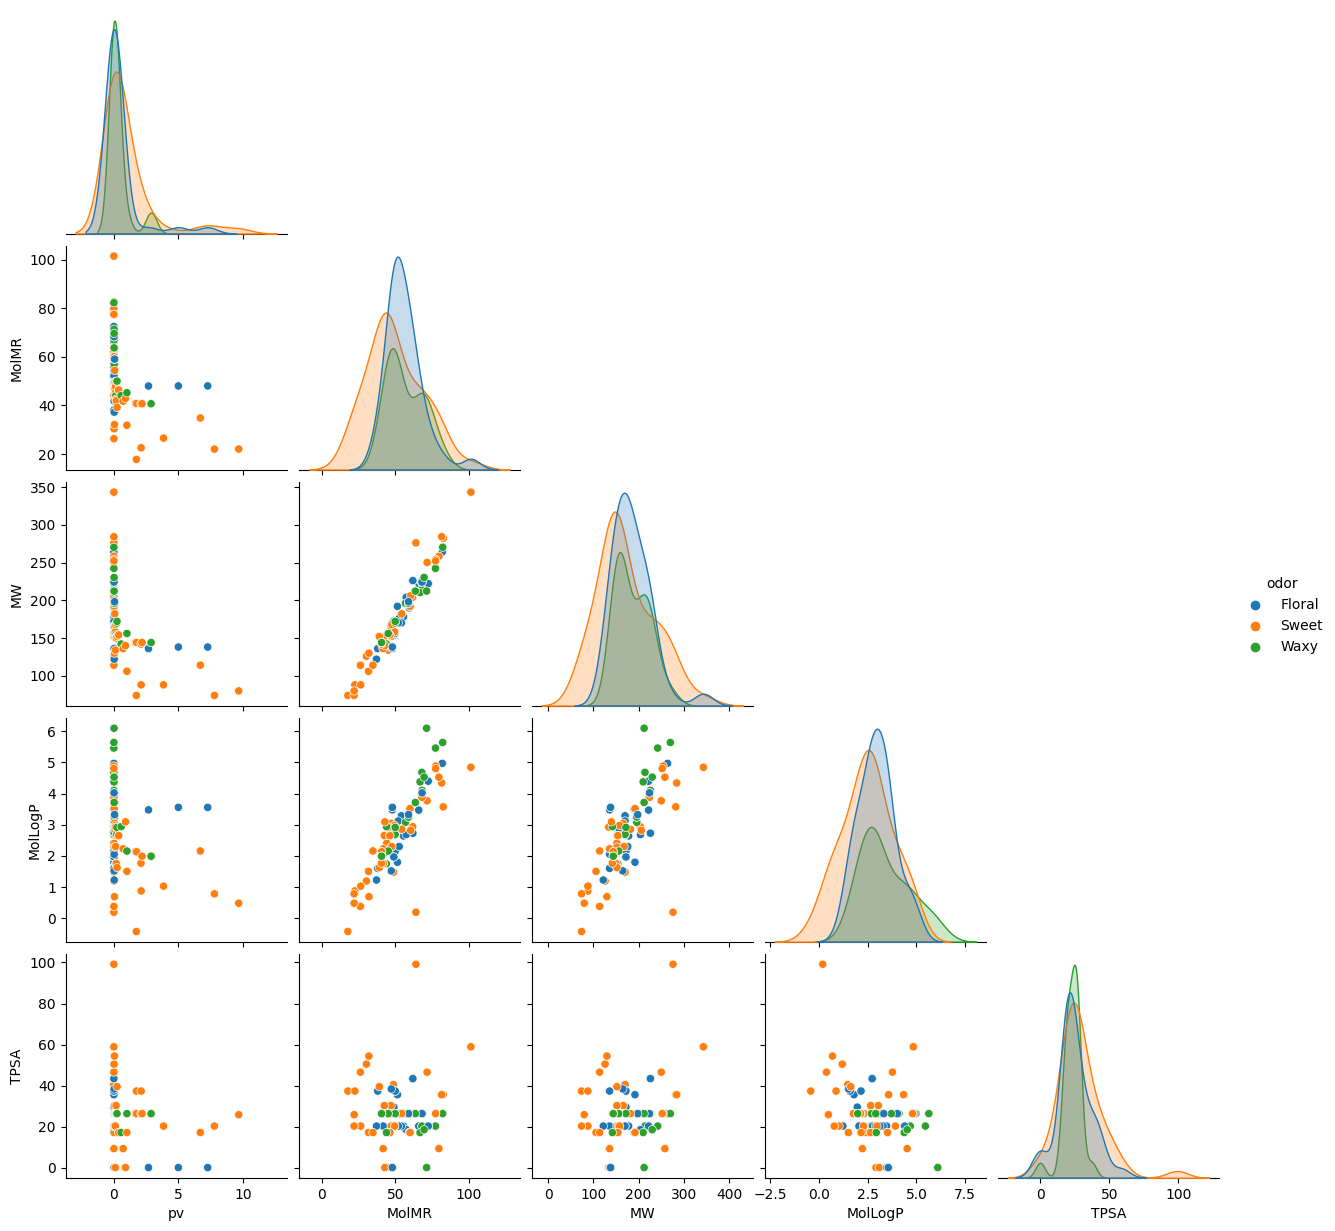

In [41]:
sns.pairplot(data_odor, hue='odor', corner = True)
plt.show()

## PCA and K-means analisys with R

In [20]:
import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.2.3"
os.environ["PATH"]   = r"C:\Program Files\R\R-4.2.3\bin\x64" + ";" + os.environ["PATH"]
import rpy2
print(rpy2.__version__)
from rpy2.robjects import pandas2ri, packages
pandas2ri.activate()
stats = packages.importr('stats')
%load_ext rpy2.ipython

3.5.11
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [22]:
%%R
library(dplyr)
library(tidyverse)
library(tidyr)
library(rstatix)
library(ggpubr)
library(ggstatsplot)
library(WRS2)
library(FactoMineR)
library(factoextra)

In [23]:
%%R -i data_odor
r_data_odor <- as.data.frame(data_odor)
r_data_odor$odor <- as.factor(r_data_odor$odor)

row.names(r_data_odor) <- r_data_odor$Name

print(class(r_data_odor))
print(class(r_data_odor$odor))

[1] "data.frame"
[1] "factor"


PCA

In [47]:
data_odor.head(2)

,CAS,Name,odor,smiles,pv,MolMR,MW,MolLogP,TPSA
0,67634-12-2,Methyl 2-[[[4-(4-hydroxy-4-methylpentyl)-3-cyc...,Floral,COC(=O)c1ccccc1N=CC2CCC(=CC2)CCCC(C)(C)O,7.790000e-10,101.5063,343.214744,4.8432,58.89
1,67634-12-2,Methyl 2-[[[4-(4-hydroxy-4-methylpentyl)-3-,Sweet,COC(=O)c1ccccc1N=CC2CCC(=CC2)CCCC(C)(C)O,7.790000e-10,101.5063,343.214744,4.8432,58.89


In [24]:
%%R 
#data_pca <- r_data_odor[,c(3,5,7:17)]
data_pca <- r_data_odor[,c(3,5:9)]
row.names(data_pca) <- r_data_odor$Name
r_pca_odor <- PCA(data_pca, scale.unit = T, graph = F, quali.sup = 1)
get_eigenvalue(r_pca_odor)

            [,1]       [,2]      [,3]
[1,] 3.124379231 62.4875846  62.48758
[2,] 1.248165231 24.9633046  87.45089
[3,] 0.571438522 11.4287704  98.87966
[4,] 0.049431384  0.9886277  99.86829
[5,] 0.006585631  0.1317126 100.00000


HCLUS

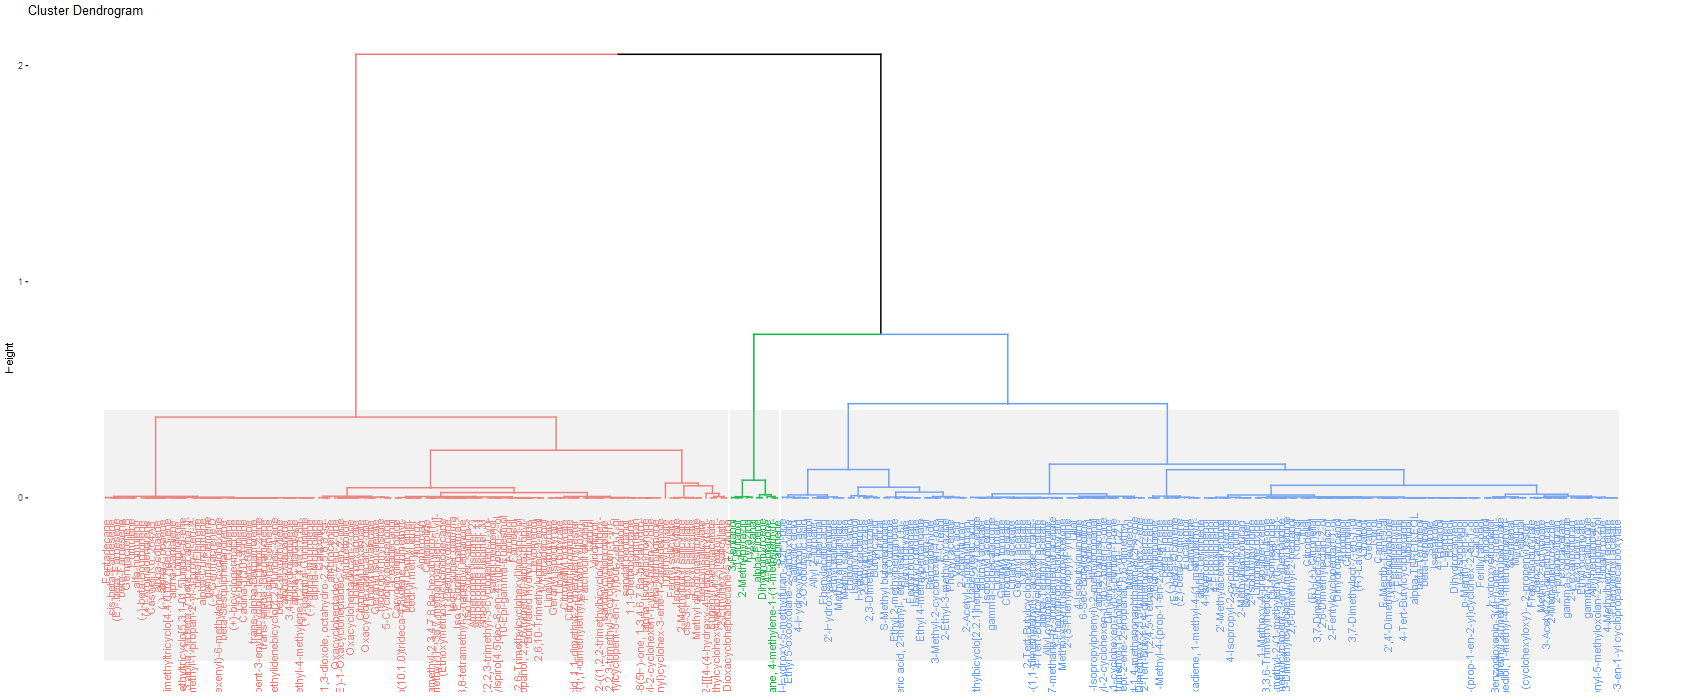

In [25]:
%%R -w 1700 -h 700 --type=cairo
hcpc <- HCPC(r_pca_odor, nb.clust = -1, graph = F, min= 3)
fviz_dend(hcpc, rect = T, rect_fill = T)

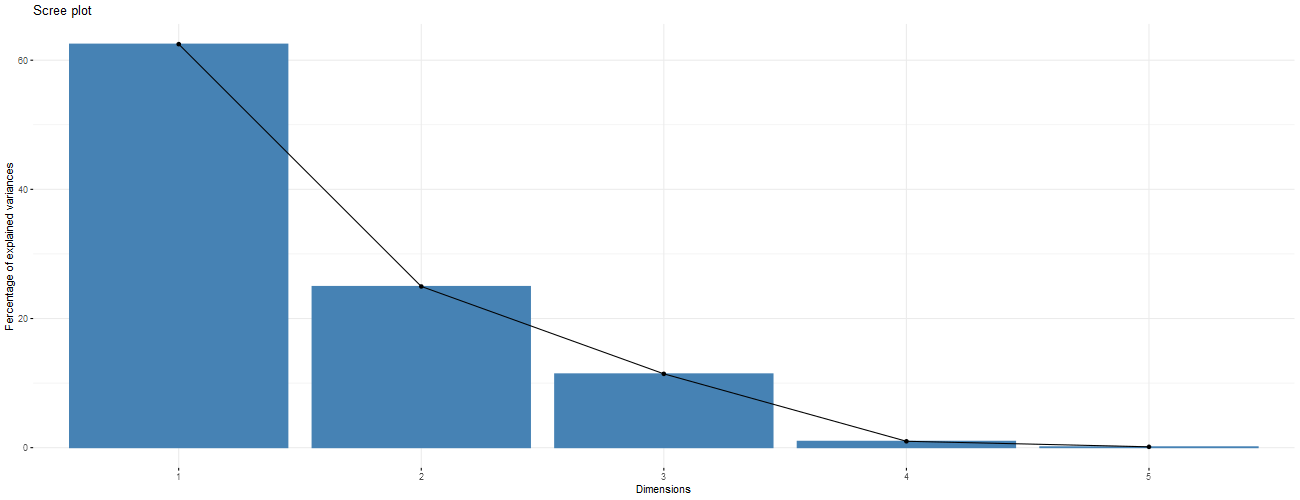

In [26]:
%%R -w 1300 -h 500 --type=cairo
fviz_screeplot(r_pca_odor)

In [51]:
%%R
head(r_data_odor,2)

                                                                                        CAS
Methyl 2-[[[4-(4-hydroxy-4-methylpentyl)-3-cyclohexenyl]methylene]amino]benzoate 67634-12-2
Methyl 2-[[[4-(4-hydroxy-4-methylpentyl)-3-                                      67634-12-2
                                                                                                                                                             Name
Methyl 2-[[[4-(4-hydroxy-4-methylpentyl)-3-cyclohexenyl]methylene]amino]benzoate Methyl 2-[[[4-(4-hydroxy-4-methylpentyl)-3-cyclohexenyl]methylene]amino]benzoate
Methyl 2-[[[4-(4-hydroxy-4-methylpentyl)-3-                                                                           Methyl 2-[[[4-(4-hydroxy-4-methylpentyl)-3-
                                                                                   odor
Methyl 2-[[[4-(4-hydroxy-4-methylpentyl)-3-cyclohexenyl]methylene]amino]benzoate Floral
Methyl 2-[[[4-(4-hydroxy-4-methylpentyl)-3-                   

Parallel analysis suggests that the number of factors =  NA  and the number of components =  2 


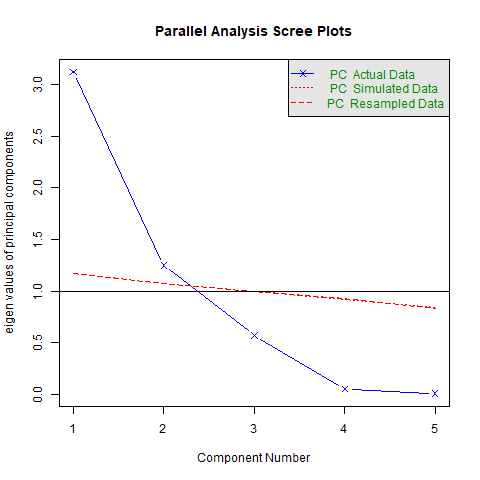

In [28]:
%%R
library(psych)
#data_pca <- r_data_odor[,c(3,5,7:16)]
fa.parallel(r_data_odor[,c(5:9)], fa='pc')

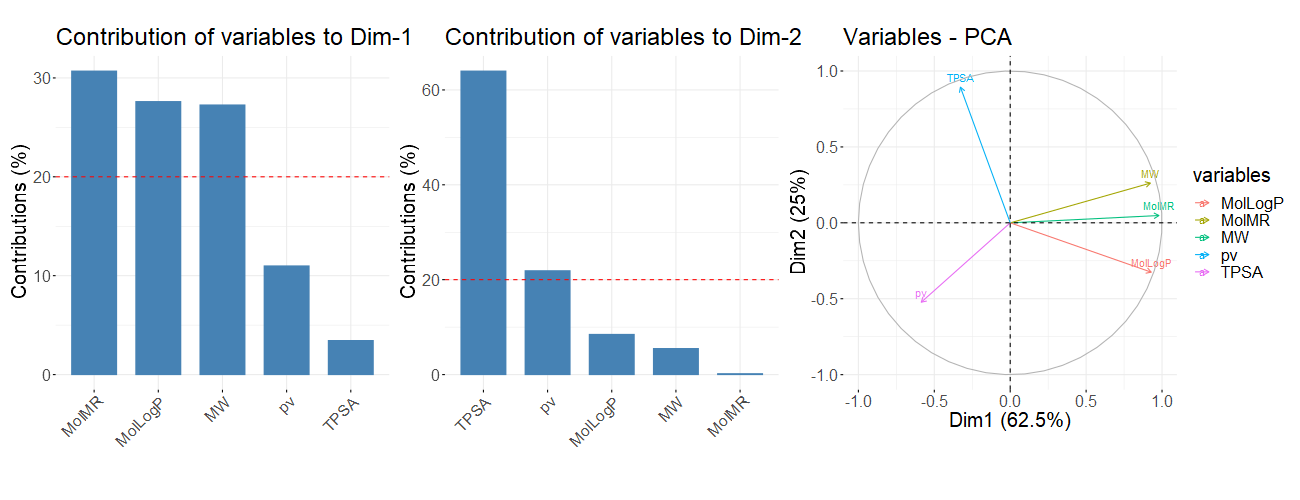

In [30]:
%%R -w 1300 -h 500 --type=cairo
q<- fviz_contrib(r_pca_odor, choice='var', axes = 1) +
            theme(text= element_text(size=20), plot.subtitle = element_text(size=20))
            
p <- fviz_contrib(r_pca_odor, choice='var', axes = 2) +
            theme(text= element_text(size=20), plot.subtitle = element_text(size=20))

r <- fviz_pca_var(r_pca_odor, col.var = factor(c("TPSA", "MW", "MolMR", "MolLogP", 'pv')),
                legend.title = list(fill = "Col", color = "variables")) +
            theme(text= element_text(size=20), plot.subtitle = element_text(size=20))
q|p|r

In [31]:
%%R -w 1300 -h 500 --type=cairo
q <- fviz_pca_var(r_pca_odor) +
            theme(text= element_text(size=20), plot.subtitle = element_text(size=20))

R[write to console]: corrplot 0.92 loaded



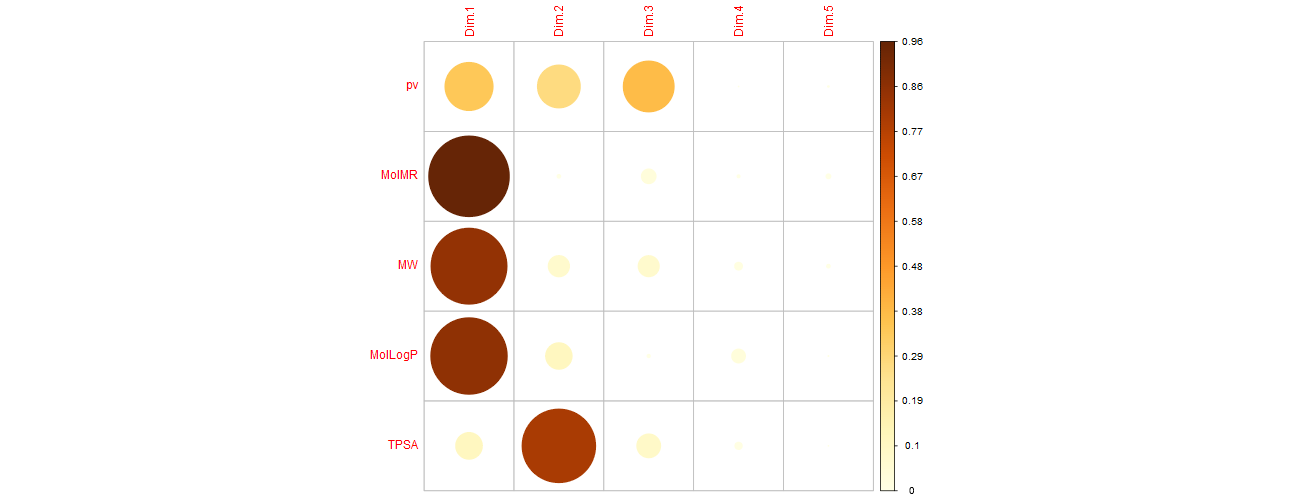

In [32]:
%%R -w 1300 -h 500 --type=cairo
library("corrplot")
var <- get_pca_var(r_pca_odor)
corrplot(var$cos2, is.corr=FALSE)

In [33]:
%%R
res_desc <- dimdesc(r_pca_odor, axes = c(1,2), proba=0.05)
res_desc$Dim.1


Link between the variable and the continuous variables (R-square)
        correlation       p.value
MolMR     0.9792868 2.305256e-207
MolLogP   0.9287778 1.278260e-129
MW        0.9229810 8.816131e-125
TPSA     -0.3279343  6.696648e-09
pv       -0.5859296  7.317022e-29

Link between the variable and the categorical variable (1-way anova)
             R2     p.value
odor 0.03973219 0.002528567

Link between variable and the categories of the categorical variables
             Estimate      p.value
odor=Woody  0.2905562 0.0135279300
odor=Sweet -0.6810859 0.0005586908


In [34]:
%%R
res_desc$Dim.2


Link between the variable and the continuous variables (R-square)
        correlation       p.value
TPSA      0.8935910 5.566395e-105
MW        0.2616673  4.692049e-06
MolLogP  -0.3250756  9.199324e-09
pv       -0.5226796  2.715452e-22

Link between the variable and the categorical variable (1-way anova)
            R2     p.value
odor 0.0364622 0.004174858

Link between variable and the categories of the categorical variables
             Estimate     p.value
odor=Sweet  0.2826154 0.002314026
odor=Woody -0.2952893 0.001534208


In [ ]:
%%R -w 1300 -h 500 --type=cairo
#pca_hcpc = PCA(r_pca_odor_clus, scale.unit = T, graph = F, quali.sup = c(1,14))

fviz_pca_biplot(pca_hcpc, repel = F, labelsize = 4,
               pointshape = 21, pointsize = 2,
             #habillage = 1, 
             addEllipses =TRUE, ellipse.alpha = 0.3,
             fill.ind = r_pca_odor_clus$odor,
             ellipse.type = "confidence", 
             #geom.ind =c("point","text"),
             geom.ind =c("point"),
             geom.var = c("text", "arrow"),
             title = 'PCA BIPLOT by ODOR',
             col.var = factor(c("TPSA", "MW", "MolMR", "MolLogP", 'pv')),

             legend.title = list(fill = "odor", color = "variables")

             ) + 
        theme(text = element_text(size = 12),
        axis.title = element_text(size =12),
        axis.text = element_text(size = 12))

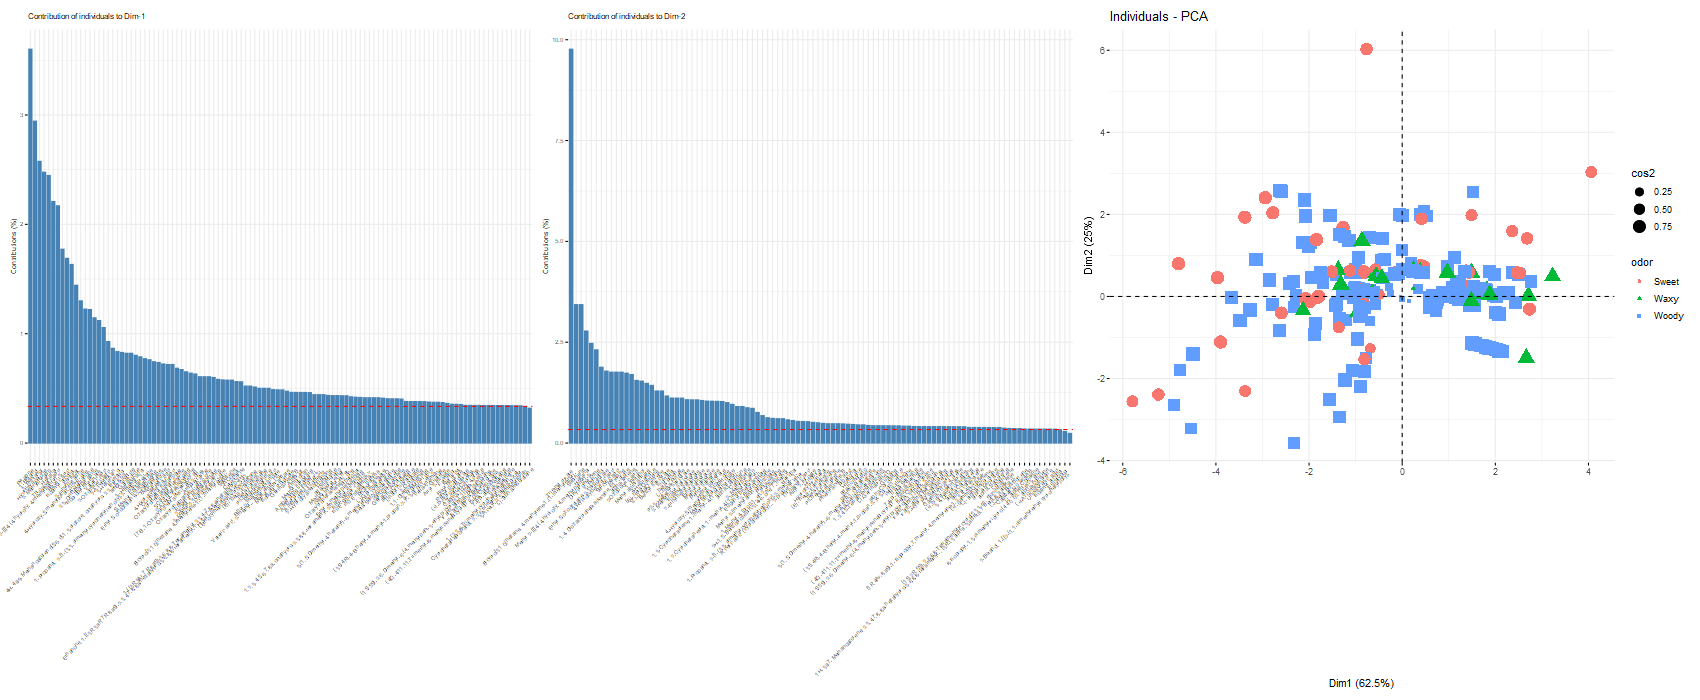

In [35]:
%%R -w 1700 -h 700 --type=cairo
n <- fviz_contrib(r_pca_odor, choice='ind', axes = 1, top =110) +
            theme(text= element_text(size=7), plot.subtitle = element_text(size=20))

m <- fviz_contrib(r_pca_odor, choice='ind', axes = 2, top = 100) +
            theme(text= element_text(size=7), plot.subtitle = element_text(size=20))

p <- fviz_pca_ind(r_pca_odor, geom.ind =c("point"), repel = F, habillage = 1,
                pointsize = "cos2")
n|m|p

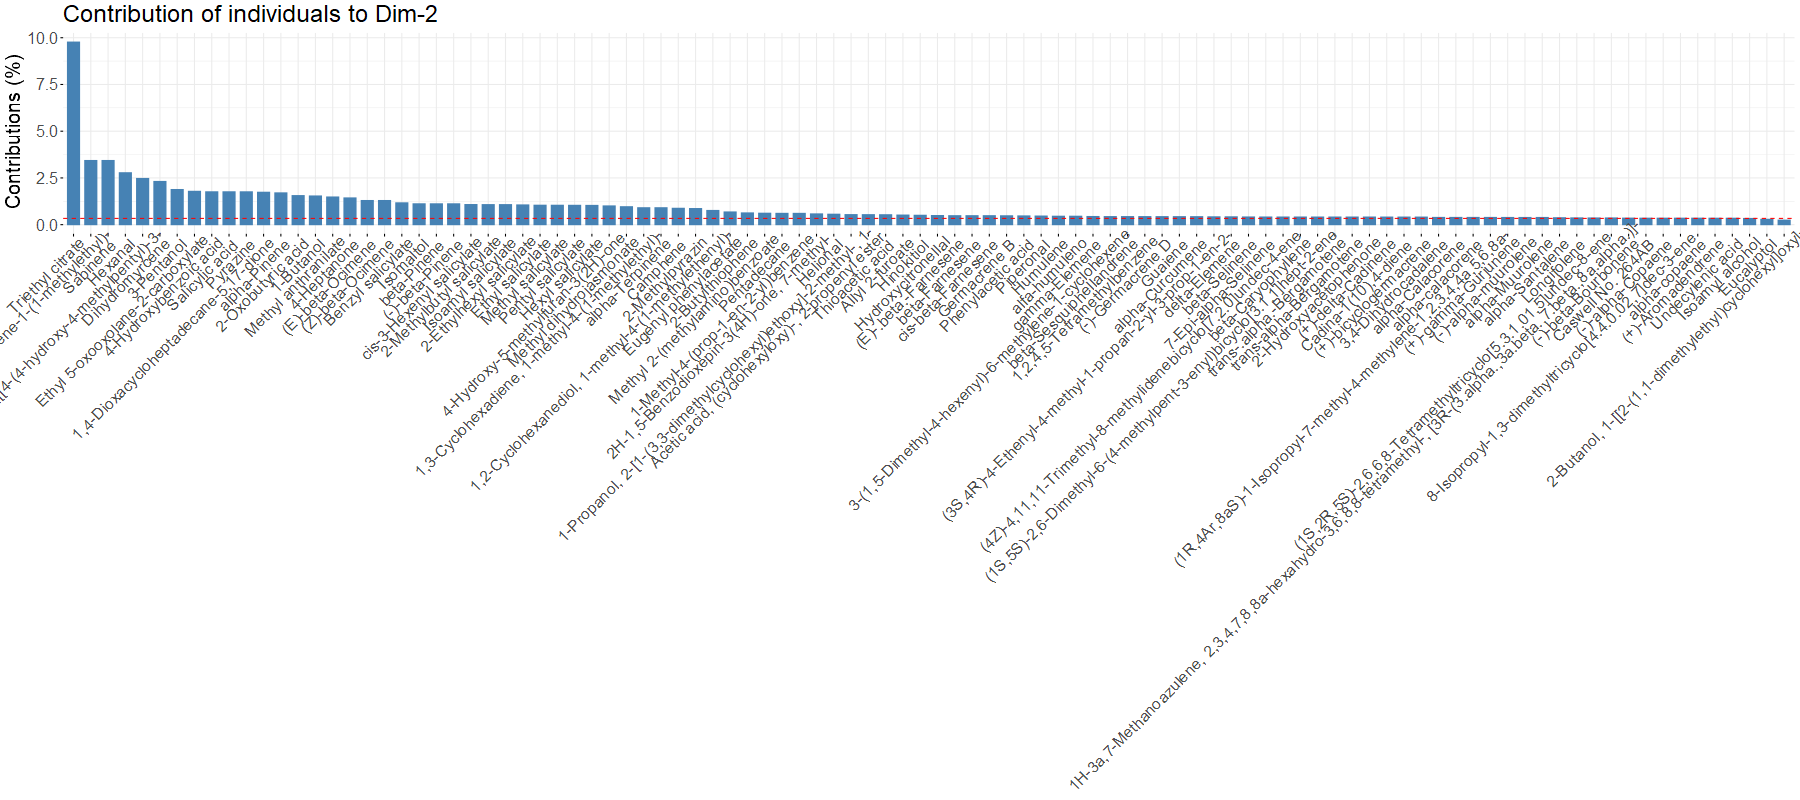

In [36]:
%%R -w 1800 -h 800 --type=cairo
fviz_contrib(r_pca_odor, choice='ind', axes = 2, top = 100) +
            theme(text= element_text(size=20), plot.subtitle = element_text(size=20))

#### HCPC Hierarchical clustering on main components 

In [ ]:
# %%R -w 1300 -h 500 --type=cairo
# hcpc <- HCPC(r_pca_odor, nb.clust = -1, graph = F, max = 3)
# fviz_dend(hcpc, rect = T, rect_fill = T)

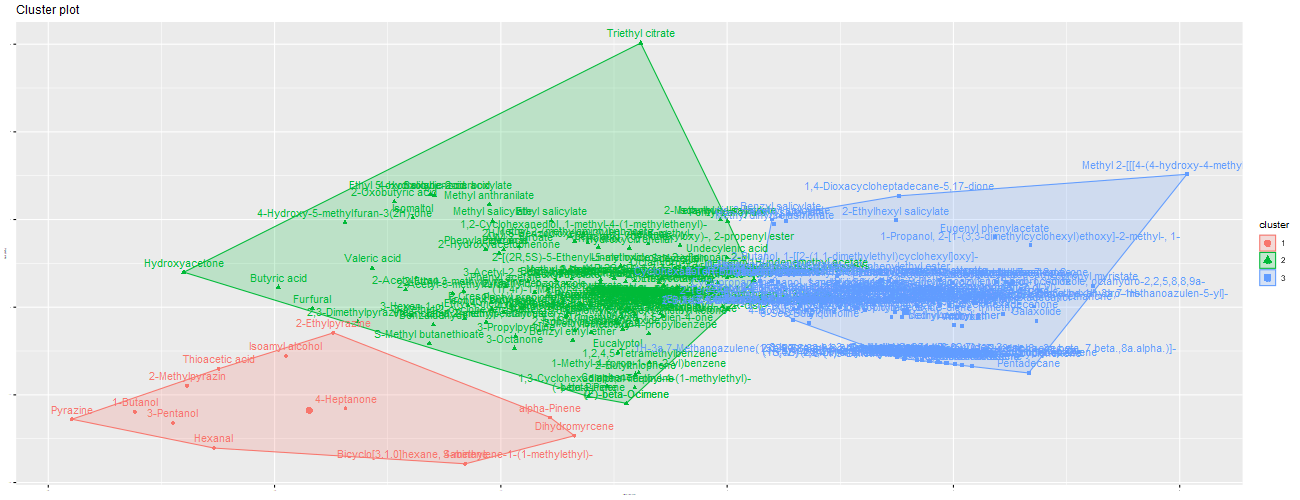

In [37]:
%%R -w 1300 -h 500 --type=cairo
fviz_cluster(hcpc, show.clust.cent =T, repel = F) +
theme(text = element_text(size = 10),
        axis.title = element_text(size =2),
        axis.text = element_text(size = 2))

In [38]:
%%R
hcpc$desc.var$category

$`1`
NULL

$`2`
            Cla/Mod  Mod/Cla   Global    p.value    v.test
odor=Woody 45.41485 71.72414 76.84564 0.04297437 -2.023959

$`3`
            Cla/Mod  Mod/Cla   Global    p.value    v.test
odor=Woody 50.65502 82.85714 76.84564 0.02100434  2.307906
odor=Sweet 31.11111 10.00000 15.10067 0.02099339 -2.308103



# **Crear data frame con los clusters**

In [66]:
%%R
## Crear data frame con los clusters
r_pca_odor_clus <- data.frame(data_pca, data.frame(clus = hcpc$data.clust$clust))
head(r_pca_odor_clus)

                                             odor       pv    MolMR       MW
Linalyl acetate                             Woody 0.00e+00  59.0330 196.1463
Hexyl acetate                               Woody 0.00e+00  40.7750 144.1150
Methyl 2-[[[4-(4-hydroxy-4-methylpentyl)-3- Sweet 7.79e-10 101.5063 343.2147
1,4-Dioxacycloheptadecane-5,17-dione        Woody 4.38e-07  72.7050 270.1831
Eugenyl phenylacetate                       Sweet 2.94e-06  82.6760 282.1256
4-Hydroxybenzoic acid                       Woody 7.03e-06  35.0661 138.0317
                                            MolLogP  TPSA clus
Linalyl acetate                              3.2406 26.30    3
Hexyl acetate                                2.1298 26.30    2
Methyl 2-[[[4-(4-hydroxy-4-methylpentyl)-3-  4.8432 58.89    3
1,4-Dioxacycloheptadecane-5,17-dione         3.3775 52.60    3
Eugenyl phenylacetate                        3.5718 35.53    3
4-Hydroxybenzoic acid                        1.0904 57.53    2


In [67]:
%%R
# Variables cuantitativas que describen mejor cada grupo
hcpc$desc.var$quanti

$`1`
           v.test Mean in category Overall mean sd in category Overall sd
pv      15.049088         6.562308    0.5235317       2.058488   1.476951
MolLogP -4.259740         1.741194    3.1428279       1.026677   1.211097
MolMR   -5.927077        32.349708   55.1443768       9.157728  14.155337
MW      -6.403422       105.316777  181.7162358      23.586637  43.914267
             p.value
pv      3.500257e-51
MolLogP 2.046649e-05
MolMR   3.083748e-09
MW      1.519326e-10

$`2`
            v.test Mean in category Overall mean sd in category Overall sd
TPSA      5.650932        24.572138    19.955738      13.353444  13.705657
MW      -11.072426       152.733997   181.716236      26.203642  43.914267
MolMR   -12.259791        44.800419    55.144377       7.507538  14.155337
MolLogP -12.369186         2.249926     3.142828       0.694216   1.211097
             p.value
TPSA    1.595805e-08
MW      1.707146e-28
MolMR   1.488839e-34
MolLogP 3.836887e-35

$`3`
           v.test Mean in ca

In [40]:
%%R
# Descripciones principales que estan mas asociadas con los grupos
hcpc$desc.axes


Link between the cluster variable and the quantitative variables
           Eta2      P-value
Dim.1 0.7825923 1.770372e-98
Dim.3 0.4737119 7.593969e-42
Dim.2 0.2363455 5.336972e-18

Description of each cluster by quantitative variables
$`1`
         v.test Mean in category  Overall mean sd in category Overall sd
Dim.3 10.475059         2.151363 -4.156351e-17      1.1091878  0.7559355
Dim.1 -7.692585        -3.694253 -8.405841e-17      1.3800464  1.7675914
Dim.2 -7.755041        -2.353925 -1.797011e-17      0.8810884  1.1172132
           p.value
Dim.3 1.124677e-25
Dim.1 1.441922e-14
Dim.2 8.831504e-15

$`2`
          v.test Mean in category  Overall mean sd in category Overall sd
Dim.2   4.713901        0.3139062 -1.797011e-17      1.0472635  1.1172132
Dim.3  -7.620997       -0.3433840 -4.156351e-17      0.4853941  0.7559355
Dim.1 -11.275544       -1.1879629 -8.405841e-17      0.8893378  1.7675914
           p.value
Dim.2 2.430193e-06
Dim.3 2.517229e-14
Dim.1 1.733037e-29

$`3`
      

In [45]:
%%R
# Individuos representativos de cada grupo 
hcpc$desc.ind

$para
Cluster: 1
    4-Heptanone 2-Methylpyrazin       1-Butanol      3-Pentanol Thioacetic acid 
      0.4718251       1.3149548       1.5841648       1.5965202       1.8697976 
------------------------------------------------------------ 
Cluster: 2
     gamma-Nonalactone  1-Phenylethyl acetate     Prenyl isobutyrate 
             0.3626067              0.4018175              0.4019961 
            4-Thujanol 4-Methylbenzyl acetate 
             0.4106790              0.4494803 
------------------------------------------------------------ 
Cluster: 3
                      2,6,10-Trimethylundec-9-enal 
                                         0.2760547 
13-Oxabicyclo(10.1.0)trideca-4,8-diene, trimethyl- 
                                         0.3040667 
                               Caryophyllene oxide 
                                         0.3377409 
                             10-Epi-gamma-Eudesmol 
                                         0.3608474 
                         

In [53]:
%%R
# Individuos representativos de cada grupo 
hcpc$desc.ind$para

Cluster: 1
    4-Heptanone 2-Methylpyrazin       1-Butanol      3-Pentanol Thioacetic acid 
      0.4718251       1.3149548       1.5841648       1.5965202       1.8697976 
------------------------------------------------------------ 
Cluster: 2
     gamma-Nonalactone  1-Phenylethyl acetate     Prenyl isobutyrate 
             0.3626067              0.4018175              0.4019961 
            4-Thujanol 4-Methylbenzyl acetate 
             0.4106790              0.4494803 
------------------------------------------------------------ 
Cluster: 3
                      2,6,10-Trimethylundec-9-enal 
                                         0.2760547 
13-Oxabicyclo(10.1.0)trideca-4,8-diene, trimethyl- 
                                         0.3040667 
                               Caryophyllene oxide 
                                         0.3377409 
                             10-Epi-gamma-Eudesmol 
                                         0.3608474 
                          Butyl

In [54]:
%%R
# Individuos representativos de cada grupo 
hcpc$desc.ind$dist

Cluster: 1
       Pyrazine         Hexanal      3-Pentanol       1-Butanol 2-Methylpyrazin 
       6.795043        6.395202        5.897309        5.644292        5.117037 
------------------------------------------------------------ 
Cluster: 2
                 Triethyl citrate                 2-Oxobutyric acid 
                         7.059849                          5.186209 
4-Hydroxy-5-methylfuran-3(2H)-one  Ethyl 5-oxooxolane-2-carboxylate 
                         5.155769                          4.996329 
            4-Hydroxybenzoic acid 
                         4.970779 
------------------------------------------------------------ 
Cluster: 3
                   Methyl 2-[[[4-(4-hydroxy-4-methylpentyl)-3- 
                                                      6.768996 
                                           Isopropyl myristate 
                                                      4.704395 
1-Propanol, 2-[1-(3,3-dimethylcyclohexyl)ethoxy]-2-methyl-, 1- 
               

In [73]:
%%R
head(r_pca_odor_clus,1)

                 odor pv  MolMR       MW MolLogP TPSA clus
Linalyl acetate Woody  0 59.033 196.1463  3.2406 26.3    3


In [74]:
%%R
head(r_pca_odor_clus,2)

                 odor pv  MolMR       MW MolLogP TPSA clus
Linalyl acetate Woody  0 59.033 196.1463  3.2406 26.3    3
Hexyl acetate   Woody  0 40.775 144.1150  2.1298 26.3    2


In [55]:
%%R
r_pca_odor_clus$clus <- as.factor(r_pca_odor_clus$clus)
head(r_pca_odor_clus,2)

                 odor pv  MolMR       MW MolLogP TPSA clus
Linalyl acetate Woody  0 59.033 196.1463  3.2406 26.3    3
Hexyl acetate   Woody  0 40.775 144.1150  2.1298 26.3    2


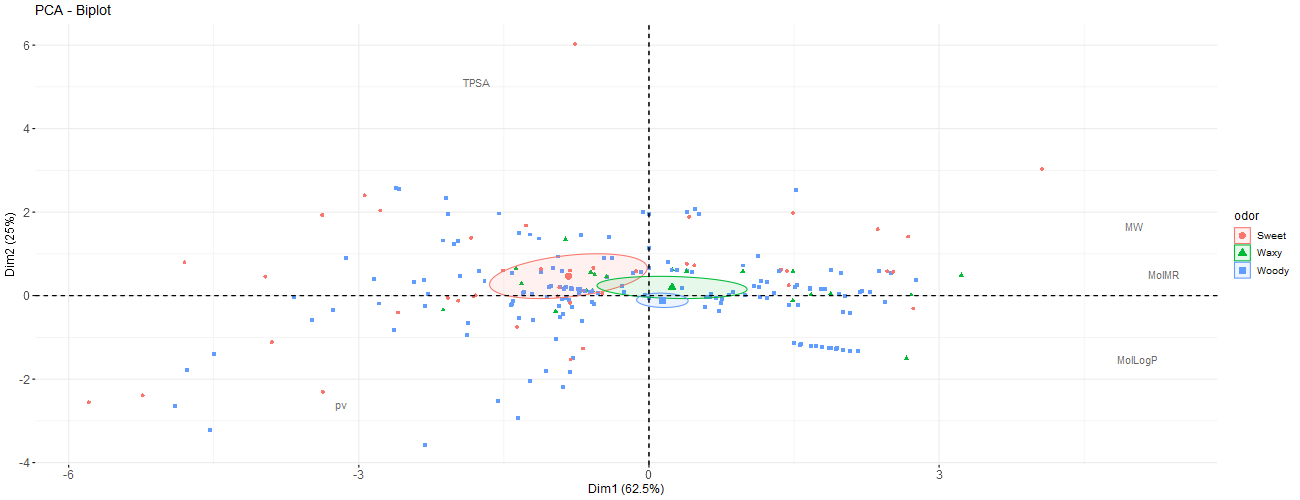

In [58]:
%%R -w 1300 -h 500 --type=cairo
#pca_hcpc = PCA(r_pca_odor_clus, scale.unit = T, graph = F, quali.sup = c(1,14))
pca_hcpc = PCA(r_pca_odor_clus, scale.unit = T, graph = F, quali.sup = c(1,7))

fviz_pca_biplot(pca_hcpc, repel = F, labelsize = 4,
             habillage = 1, addEllipses =TRUE, 
             ellipse.type = "confidence", palette = "aaas",
             #geom.ind =c("point","text"),
             geom.ind =c("point"),
             #geom.var = c("text", "arrow"),
             geom.var = c("text"),
             col.var = "gray40"
             
             ) + 
        theme(text = element_text(size = 12),
        axis.title = element_text(size =12),
        axis.text = element_text(size = 12))

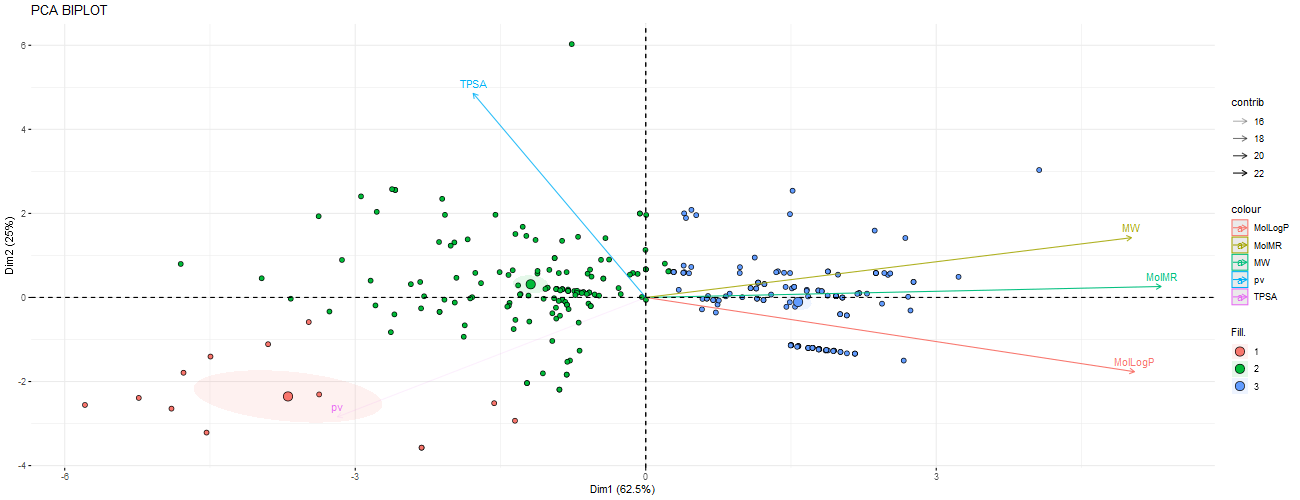

In [59]:
%%R -w 1300 -h 500 --type=cairo
#pca_hcpc = PCA(r_pca_odor_clus, scale.unit = T, graph = F, quali.sup = c(1,14))

fviz_pca_biplot(pca_hcpc, repel = F, labelsize = 4,
            fill.ind = r_pca_odor_clus$clus, col.ind = "black",
            pointshape = 21, pointsize = 2,
             addEllipses =TRUE, 
             ellipse.type = "confidence",
             #geom.ind =c("point","text"),
             geom.ind =c("point"),
             geom.var = c("text", "arrow"),
             alpha.var ="contrib", 
             col.var = factor(c("TPSA", "MW", "MolMR", "MolLogP", 'pv')),
            
             title = 'PCA BIPLOT'
             ) 

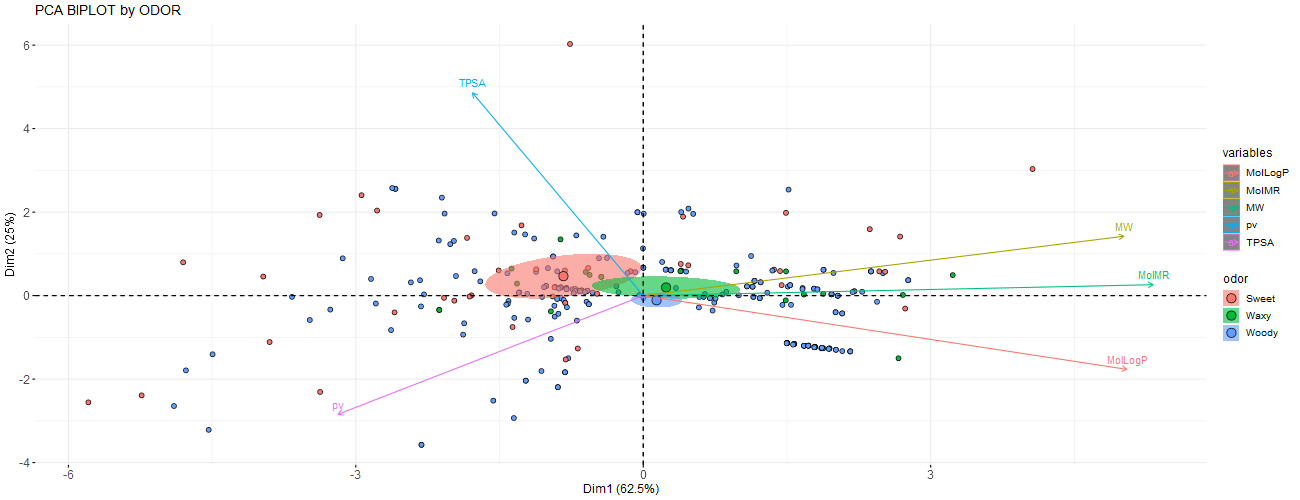

In [71]:
%%R -w 1300 -h 500 --type=cairo
#pca_hcpc = PCA(r_pca_odor_clus, scale.unit = T, graph = F, quali.sup = c(1,14))

odor_plot <- fviz_pca_biplot(pca_hcpc, repel = F, labelsize = 4,
               pointshape = 21, pointsize = 2,
             #habillage = 1, 
             addEllipses =TRUE, ellipse.alpha = 0.6,
             fill.ind = r_pca_odor_clus$odor,
             ellipse.type = "confidence", 
             #geom.ind =c("point","text"),
             geom.ind =c("point"),
             geom.var = c("text", "arrow"),
             title = 'PCA BIPLOT by ODOR',
             col.var = factor(c("TPSA", "MW", "MolMR", "MolLogP", 'pv')),

             legend.title = list(fill = "odor", color = "variables")

             ) + 
        theme(text = element_text(size = 12),
        axis.title = element_text(size =12),
        axis.text = element_text(size = 12))
odor_plot

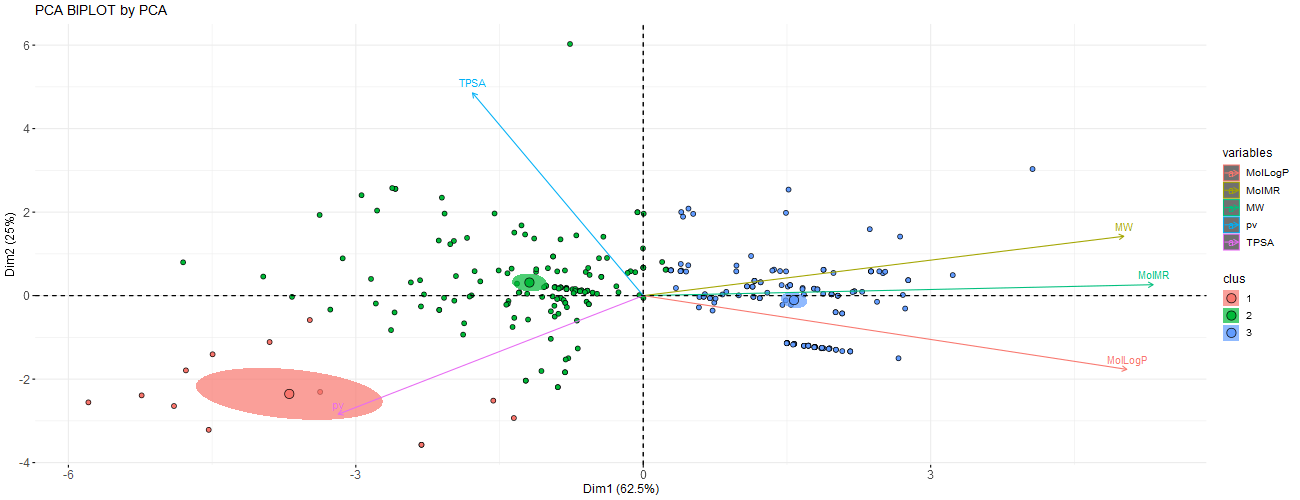

In [68]:
%%R -w 1300 -h 500 --type=cairo
#pca_hcpc = PCA(r_pca_odor_clus, scale.unit = T, graph = F, quali.sup = c(1,14))

clust_plot <- fviz_pca_biplot(pca_hcpc, repel = F, labelsize = 4,
               pointshape = 21, 
               pointsize = 2,
             #habillage = 7, 
             addEllipses =TRUE,  ellipse.alpha = 0.7,
             fill.ind = r_pca_odor_clus$clus,
             ellipse.type = "confidence", 
             #geom.ind =c("point","text"),
             geom.ind =c("point"),
             geom.var = c("text", "arrow"),
             title = 'PCA BIPLOT by PCA',
             col.var = factor(c("TPSA", "MW", "MolMR", "MolLogP", 'pv')),

             legend.title = list(fill = "clus", color = "variables")

             ) + 
        theme(text = element_text(size = 12),
        axis.title = element_text(size =12),
        axis.text = element_text(size = 12))
clust_plot

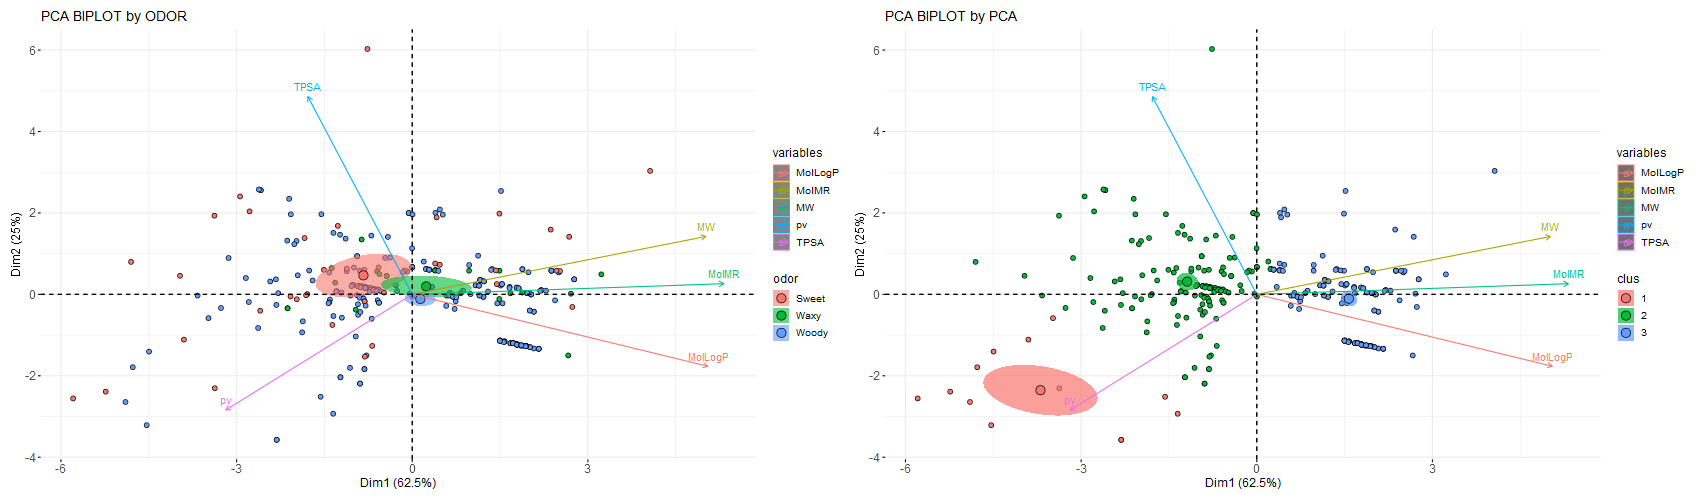

In [72]:
%%R -w 1700 -h 500 --type=cairo
odor_plot|clust_plot

# Analisis ANOVA2EG

In [73]:
%%R
r_pca_odor_clus %>%
    group_by(clus) %>%
    get_summary_stats(pv, type = 'mean_sd')

# A tibble: 3 x 5
  clus  variable     n  mean    sd
  <fct> <fct>    <dbl> <dbl> <dbl>
1 1     pv          13 6.56  2.14 
2 2     pv         145 0.473 0.765
3 3     pv         140 0.015 0.021


In [74]:
%%R
r_pca_odor_clus %>%
    group_by(odor) %>%
    get_summary_stats(pv, type = 'mean_sd')

# A tibble: 3 x 5
  odor  variable     n  mean    sd
  <fct> <fct>    <dbl> <dbl> <dbl>
1 Sweet pv          45 0.981 2.11 
2 Waxy  pv          24 0.34  0.815
3 Woody pv         229 0.453 1.37 


In [75]:
%%R
r_pca_odor_clus$odor <- as.factor(r_pca_odor_clus$odor)
r_pca_odor_clus$clus <- as.factor(r_pca_odor_clus$clus)
r_pca_odor_clus %>%
    group_by(odor, clus) %>%
    get_summary_stats(pv, type = 'mean_sd')

# A tibble: 8 x 6
  odor  clus  variable     n  mean    sd
  <fct> <fct> <fct>    <dbl> <dbl> <dbl>
1 Sweet 1     pv           4 6.99  2.43 
2 Sweet 2     pv          27 0.598 0.777
3 Sweet 3     pv          14 0.004 0.006
4 Waxy  2     pv          14 0.574 1.02 
5 Waxy  3     pv          10 0.012 0.014
6 Woody 1     pv           9 6.37  2.13 
7 Woody 2     pv         104 0.427 0.727
8 Woody 3     pv         116 0.017 0.023


In [90]:
%%R -w 1300 -h 500 --type=cairo
clus_box <- ggboxplot(r_pca_odor_clus,  
            x = 'clus',
            y = 'pv', 
            color = "clus",
            add = c("jitter"),
            fill = "clus", alpha = 0.2) +
             stat_summary(fun = mean, geom = "point", shape = 18, size = 7,
               color = "darkred",
               position = position_dodge(width = 1)) +
            stat_summary(fun = mean, colour = "red", 
               position = position_dodge(width = 1),
               geom = "text", vjust = -0.7,  size = 7,
               aes(label = round(..y.., digits = 5))) +
               ggtitle('Vapor pressure mean among clusters')

In [91]:
%%R -w 1300 -h 500 --type=cairo
odor_clus <- ggboxplot(r_pca_odor_clus,  
            x = 'odor',
            y = 'pv', 
            color = "odor",
            add = c("jitter"),
            fill = "odor", alpha = 0.2) +
             stat_summary(fun = mean, geom = "point", shape = 18, size = 7,
               color = "darkred",
               position = position_dodge(width = 1)) +
            stat_summary(fun = mean, colour = "red", 
               position = position_dodge(width = 1),
               geom = "text", vjust = -0.7,  size = 7,
               aes(label = round(..y.., digits = 5))) +
               ggtitle('Vapor pressure mean among odor descriptors')

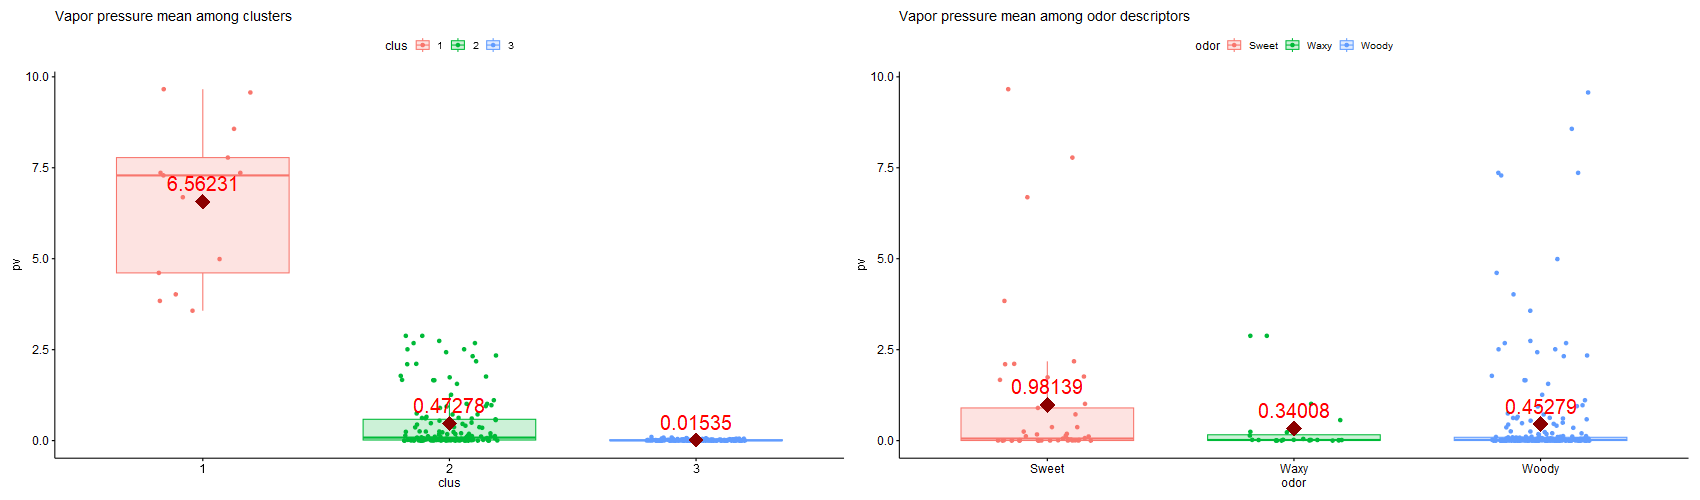

In [93]:
%%R -w 1700 -h 500 --type=cairo
clus_box|odor_clus

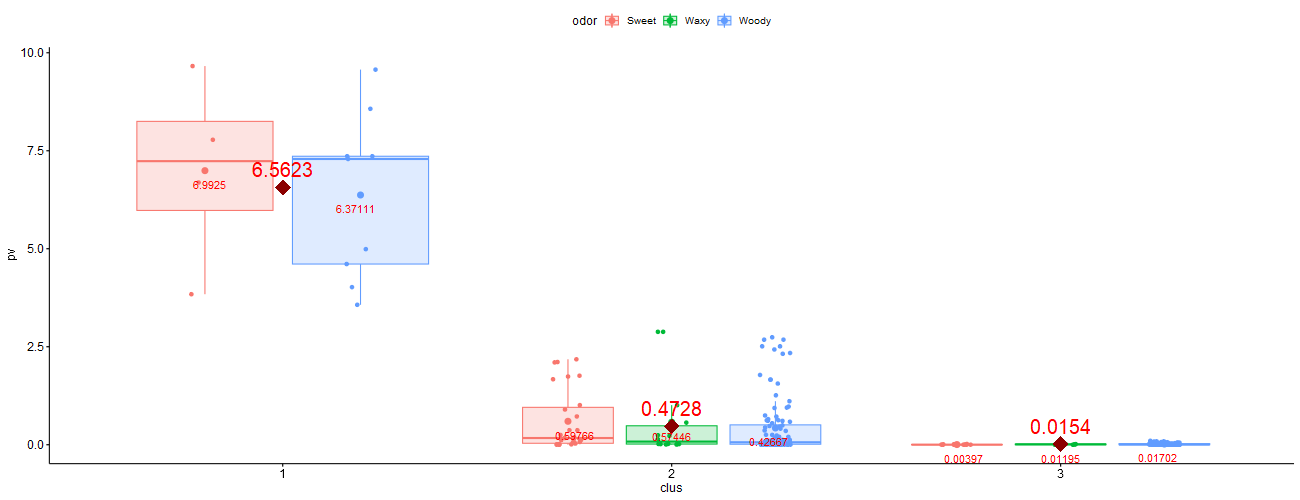

In [94]:
%%R -w 1300 -h 500 --type=cairo
ggboxplot(r_pca_odor_clus,  
            x = 'clus',
            y = 'pv', 
            color = "odor",
            add = c("mean","jitter"),
            fill = "odor", alpha = 0.2) +
             stat_summary(fun = mean, geom = "point", shape = 18, size = 7,
               color = "darkred",
               position = position_dodge(width = 1)) +
            stat_summary(fun = mean, colour = "red", 
               position = position_dodge(width = 1),
               geom = "text", vjust = -0.7,  size = 7,
               aes(label = round(..y.., digits = 4))) +
            stat_summary(fun = mean, colour = "red", 
               position = position_dodge(width = 0.75),
               geom = "text", vjust = 2.3, 
               aes(label = round(..y.., digits = 5), group = odor)) 

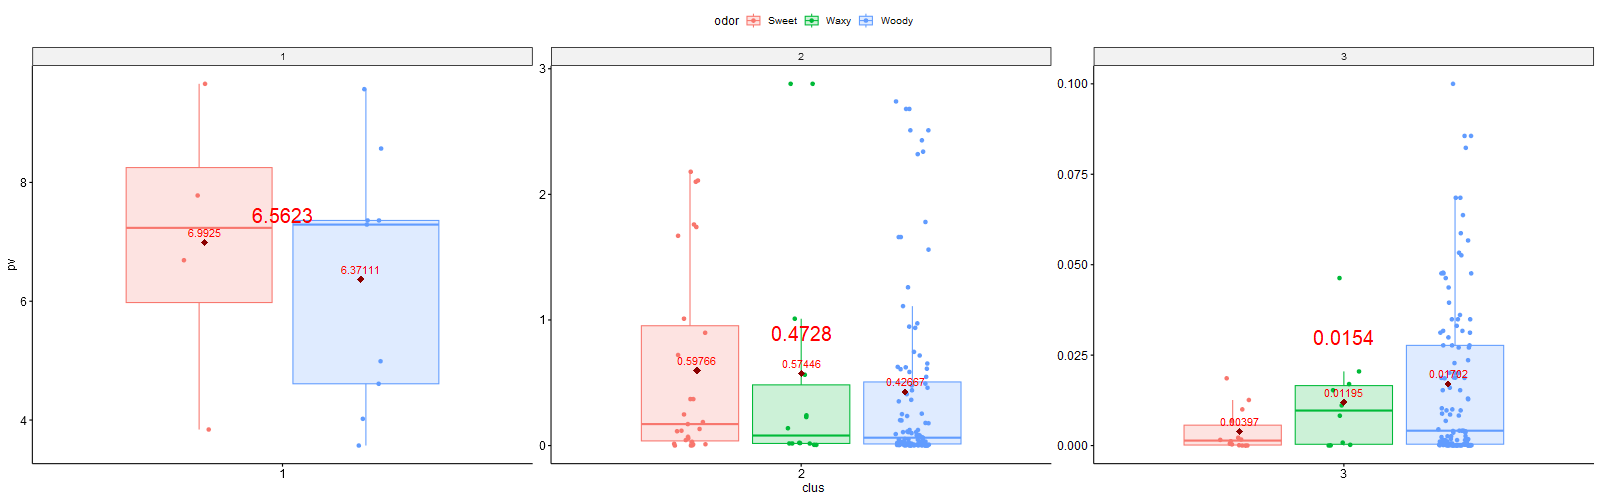

In [96]:
%%R -w 1600 -h 500 --type=cairo
ggboxplot(r_pca_odor_clus,  
            x = 'clus',
            y = 'pv', 
            color = "odor",
            add = c("jitter"),
            fill = "odor", alpha = 0.2) +
             stat_summary(fun = mean, geom = "point", shape = 18, size = 3,
               aes(group = odor), color = "darkred",
               position = position_dodge(width = 0.75)) +
            stat_summary(fun = mean, colour = "red", 
               position = position_dodge(width = 0.75),
               geom = "text", vjust = -0.7, 
               aes(label = round(..y.., digits = 5), group = odor)) +
            stat_summary(fun = mean, colour = "red", 
               position = position_dodge(width = 1),
               geom = "text", vjust = -3,  size = 7,
               aes(label = round(..y.., digits = 4))) +
            facet_wrap(~clus, ncol=3, scales="free")

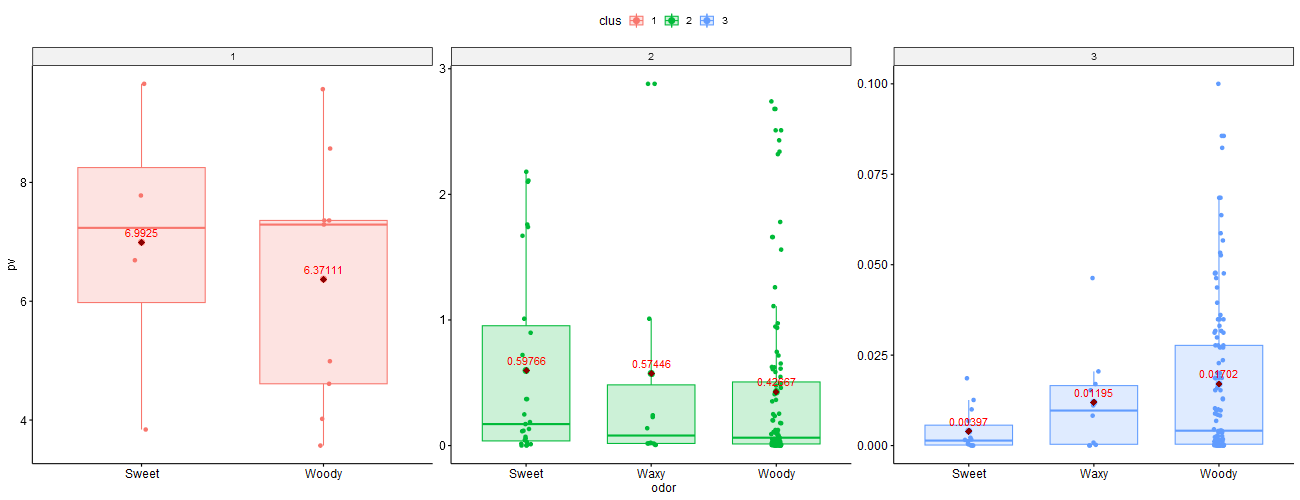

In [79]:
%%R -w 1300 -h 500 --type=cairo
ggboxplot(r_pca_odor_clus,
            x = 'odor',
            y = 'pv', 
            color = "clus",
            add = c("mean", "jitter"),
            fill = "clus", alpha = 0.2) +
        stat_summary(fun = mean, geom = "point", shape = 18, size = 3,
               aes(group = clus), color = "darkred",
               position = position_dodge(width = 0.75)) +
            stat_summary(fun = mean, colour = "red", 
               position = position_dodge(width = 0.75),
               geom = "text", vjust = -0.7, 
               aes(label = round(..y.., digits = 5), group = clus)) +
            facet_wrap(~clus, ncol=3, scales="free")

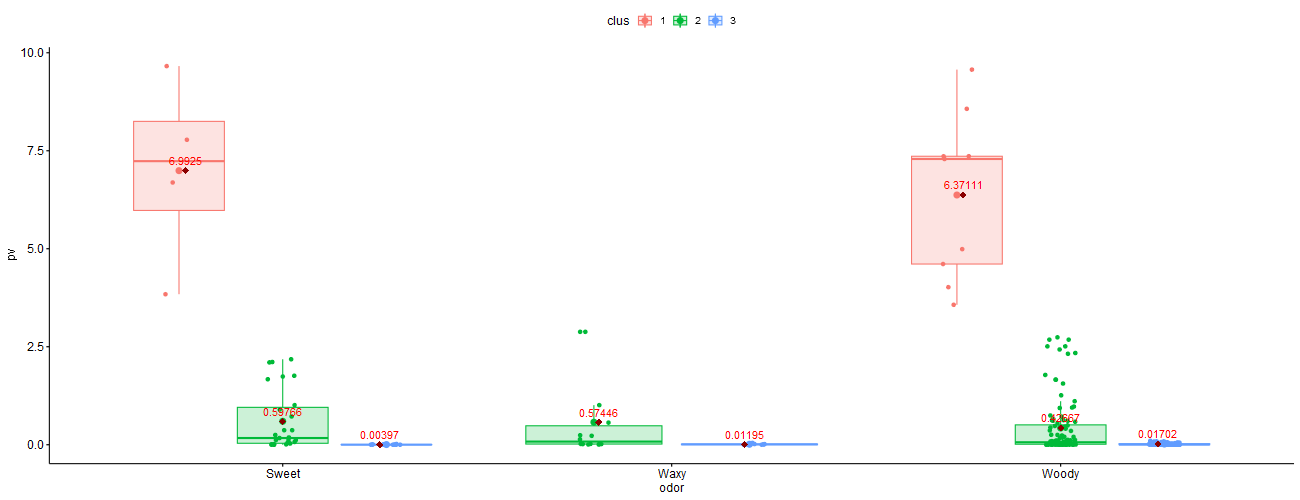

In [85]:
%%R -w 1300 -h 500 --type=cairo
ggboxplot(r_pca_odor_clus,
            x = 'odor',
            y = 'pv', 
            color = "clus",
            add = c("mean", "jitter"),
            fill = "clus", alpha = 0.2) +
        stat_summary(fun = mean, geom = "point", shape = 18, size = 3,
               aes(group = clus), color = "darkred",
               position = position_dodge(width = 0.75)) +
            stat_summary(fun = mean, colour = "red", 
               position = position_dodge(width = 0.75),
               geom = "text", vjust = -0.7, 
               aes(label = round(..y.., digits = 5), group = clus)) 

In [113]:
%%R
# Normalidad
r_pca_odor_clus %>%
    group_by(clus, odor) %>%
    shapiro_test(pv)

# A tibble: 8 x 5
  odor  clus  variable statistic        p
  <fct> <fct> <chr>        <dbl>    <dbl>
1 Sweet 1     pv           0.984 9.25e- 1
2 Woody 1     pv           0.921 4.00e- 1
3 Sweet 2     pv           0.742 1.60e- 5
4 Waxy  2     pv           0.605 4.53e- 5
5 Woody 2     pv           0.631 8.61e-15
6 Sweet 3     pv           0.727 7.16e- 4
7 Waxy  3     pv           0.813 2.07e- 2
8 Woody 3     pv           0.770 3.32e-12


In [114]:
%%R
# homogeneidad de varianza
r_pca_odor_clus %>%
    levene_test(pv ~ clus*odor)

# A tibble: 1 x 4
    df1   df2 statistic        p
  <int> <int>     <dbl>    <dbl>
1     7   290      17.7 1.51e-19


In [115]:
%%R
# valores atípicos
r_pca_odor_clus %>%
    group_by(clus, odor)%>%
    identify_outliers(pv)

# A tibble: 21 x 9
   odor  clus     pv MolMR    MW MolLogP  TPSA is.outlier is.extreme
   <fct> <fct> <dbl> <dbl> <dbl>   <dbl> <dbl> <lgl>      <lgl>     
 1 Waxy  2      2.88  40.7 144.     1.99 26.3  TRUE       TRUE      
 2 Waxy  2      2.88  40.7 144.     1.99 26.3  TRUE       TRUE      
 3 Woody 2      1.26  33.4 124.     1.79 30.2  TRUE       FALSE     
 4 Woody 2      1.56  45.5 154.     2.74  9.23 TRUE       FALSE     
 5 Woody 2      1.66  45.9 136.     3.31  0    TRUE       FALSE     
 6 Woody 2      1.66  45.9 136.     3.31  0    TRUE       FALSE     
 7 Woody 2      1.78  43.8 136.     3.00  0    TRUE       FALSE     
 8 Woody 2      2.32  24.1  96.0    1.09 30.2  TRUE       TRUE      
 9 Woody 2      2.34  39.4 128.     2.55 17.1  TRUE       TRUE      
10 Woody 2      2.43  33.4 118.     1.68 17.1  TRUE       TRUE      
# i 11 more rows
# i Use `print(n = ...)` to see more rows


In [97]:
%%R
# Ajustar el modelo
r_pca_odor_clus %>%
    anova_test(pv ~ clus*odor)

ANOVA Table (type II tests)

     Effect DFn DFd       F        p p<.05   ges
1      clus   2 290 526.923 2.74e-97     * 0.784
2      odor   2 290   0.857 4.26e-01       0.006
3 clus:odor   3 290   0.734 5.32e-01       0.008


In [108]:
%%R
# Prueba post hoc para la interaccion que no es significativa
r_pca_odor_clus %>%
pairwise_t_test(pv ~ clus, p.adjust.method= "bonferroni")

# A tibble: 3 x 9
  .y.   group1 group2    n1    n2         p p.signif     p.adj p.adj.signif
* <chr> <chr>  <chr>  <int> <int>     <dbl> <chr>        <dbl> <chr>       
1 pv    1      2         13   145 1.66e- 93 ****     4.97e- 93 ****        
2 pv    1      3         13   140 1.53e-100 ****     4.59e-100 ****        
3 pv    2      3        145   140 4.54e-  8 ****     1.36e-  7 ****        


In [117]:
%%R -w 1300 -h 500 --type=cairo
anova_clus <- ggbetweenstats(data = r_pca_odor_clus, x = clus, y = pv, type = "nonparametric",
        results.subtitle = T, message = T, var.equal = F, p.adjust.method = "bonferroni", 
        title = 'Anova by Cluster',
        ggsignif.args = list(textsize = 5, tip_length = 0.01)) +
  theme(text = element_text(size = 15), plot.subtitle = element_text(size = 13))

In [116]:
%%R -w 1300 -h 500 --type=cairo
anova_odor <- ggbetweenstats(data = r_pca_odor_clus, x = odor, y = pv, type = "nonparametric",
        results.subtitle = T, message = T, var.equal = F, p.adjust.method = "bonferroni",
        title = 'Anova by Oor description',
        ggsignif.args = list(textsize = 5, tip_length = 0.01)) +
  theme(text = element_text(size = 15), plot.subtitle = element_text(size = 13))

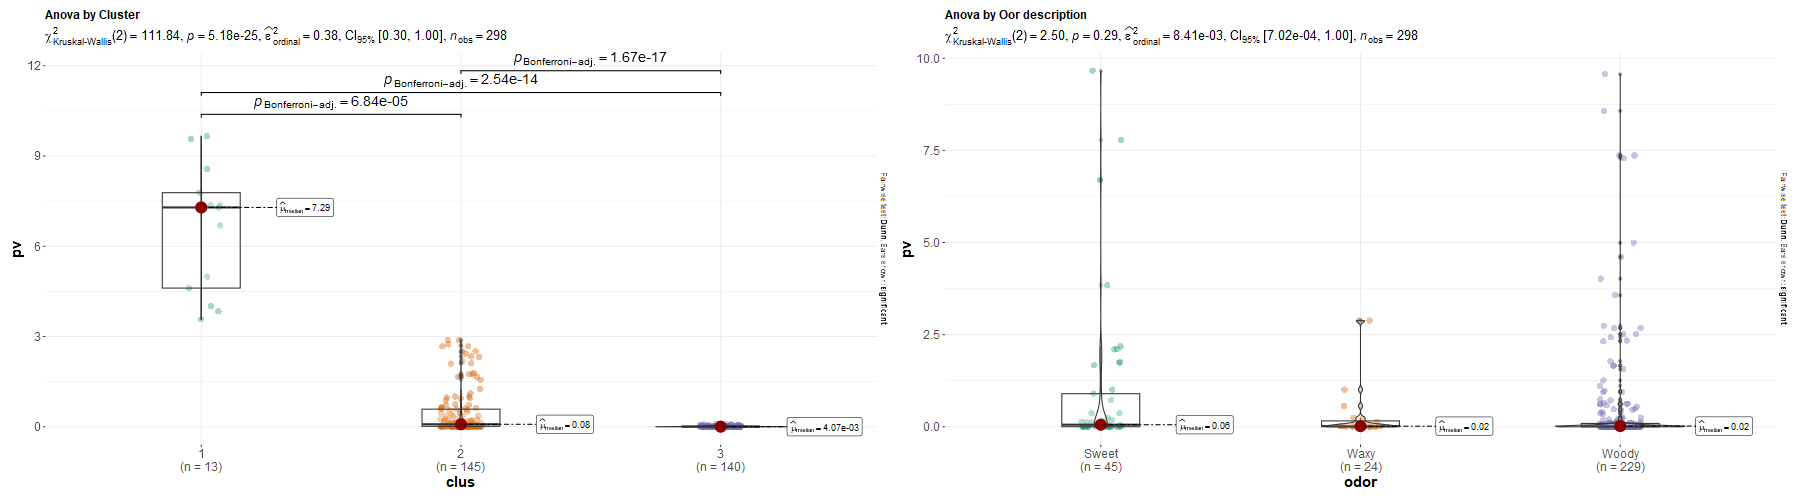

In [118]:
%%R -w 1800 -h 500 --type=cairo
anova_clus|anova_odor

In [119]:
%%R
# Prueba post hoc para la interaccion si hubiese sido significativa
r_pca_odor_clus %>%
    group_by(odor) %>%
    pairwise_t_test(pv ~ clus, p.adjust.method= "bonferroni")  

# A tibble: 7 x 10
  odor  .y.   group1 group2    n1    n2        p p.signif    p.adj p.adj.signif
* <fct> <chr> <chr>  <chr>  <int> <int>    <dbl> <chr>       <dbl> <chr>       
1 Sweet pv    1      2          4    27 9.83e-17 ****     2.95e-16 ****        
2 Sweet pv    1      3          4    14 3.25e-17 ****     9.74e-17 ****        
3 Sweet pv    2      3         27    14 4.98e- 2 *        1.49e- 1 ns          
4 Waxy  pv    2      3         14    10 9.61e- 2 ns       9.61e- 2 ns          
5 Woody pv    1      2          9   104 1.10e-72 ****     3.31e-72 ****        
6 Woody pv    1      3          9   116 4.42e-78 ****     1.33e-77 ****        
7 Woody pv    2      3        104   116 3.04e- 6 ****     9.12e- 6 ****        


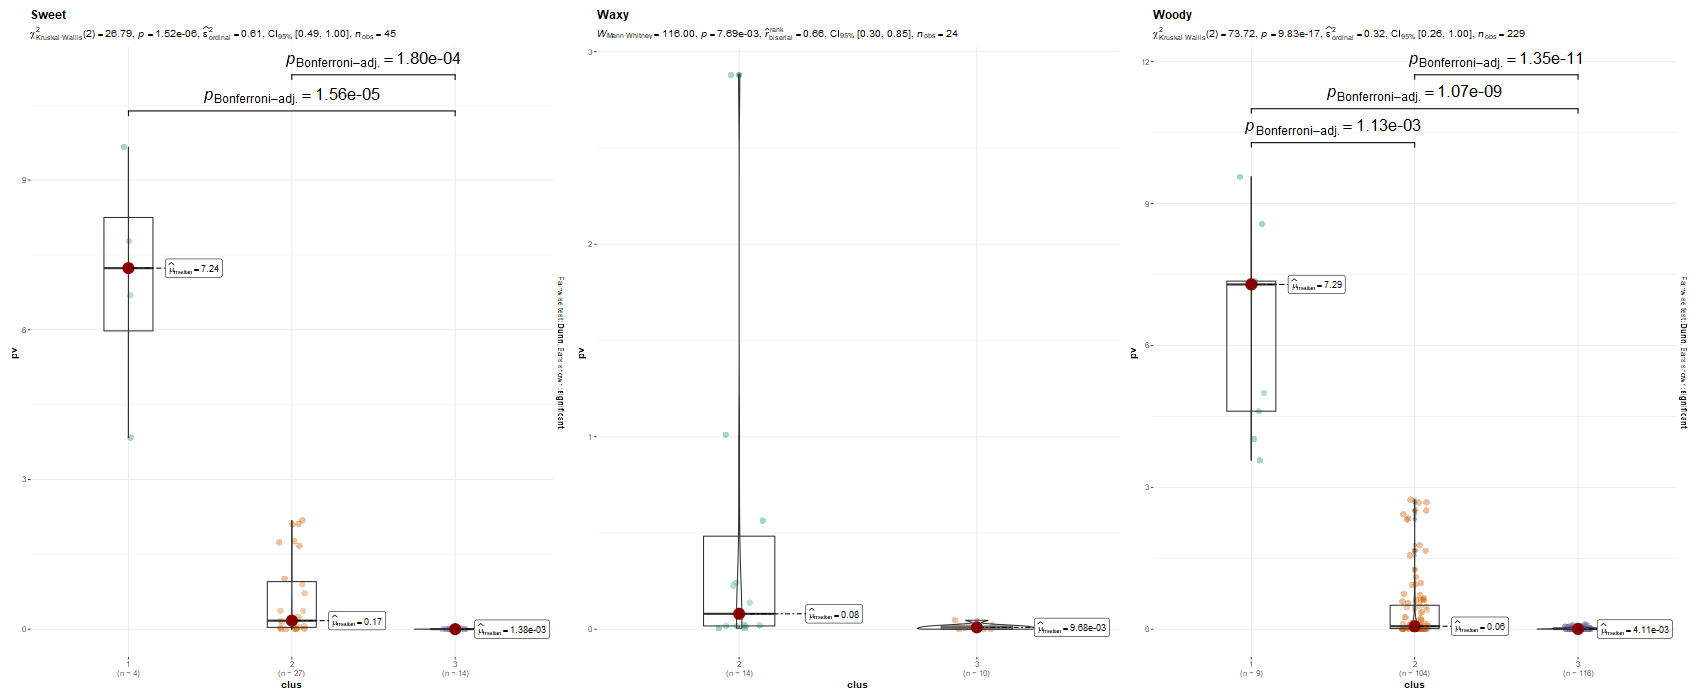

In [154]:
%%R -w 1700 -h 700 --type=cairo
library(ggthemes)
grouped_ggbetweenstats(data = r_pca_odor_clus, x = clus, y = pv,
                        grouping.var = odor, type = "nonparametric",
                    results.subtitle = T, message = T, var.equal = F, p.adjust.method = "bonferroni",
                    ggsignif.args = list(textsize = 6, tip_length = 0.01)) +
  theme(text = element_text(size = 10), plot.subtitle = element_text(size =10)) 
  

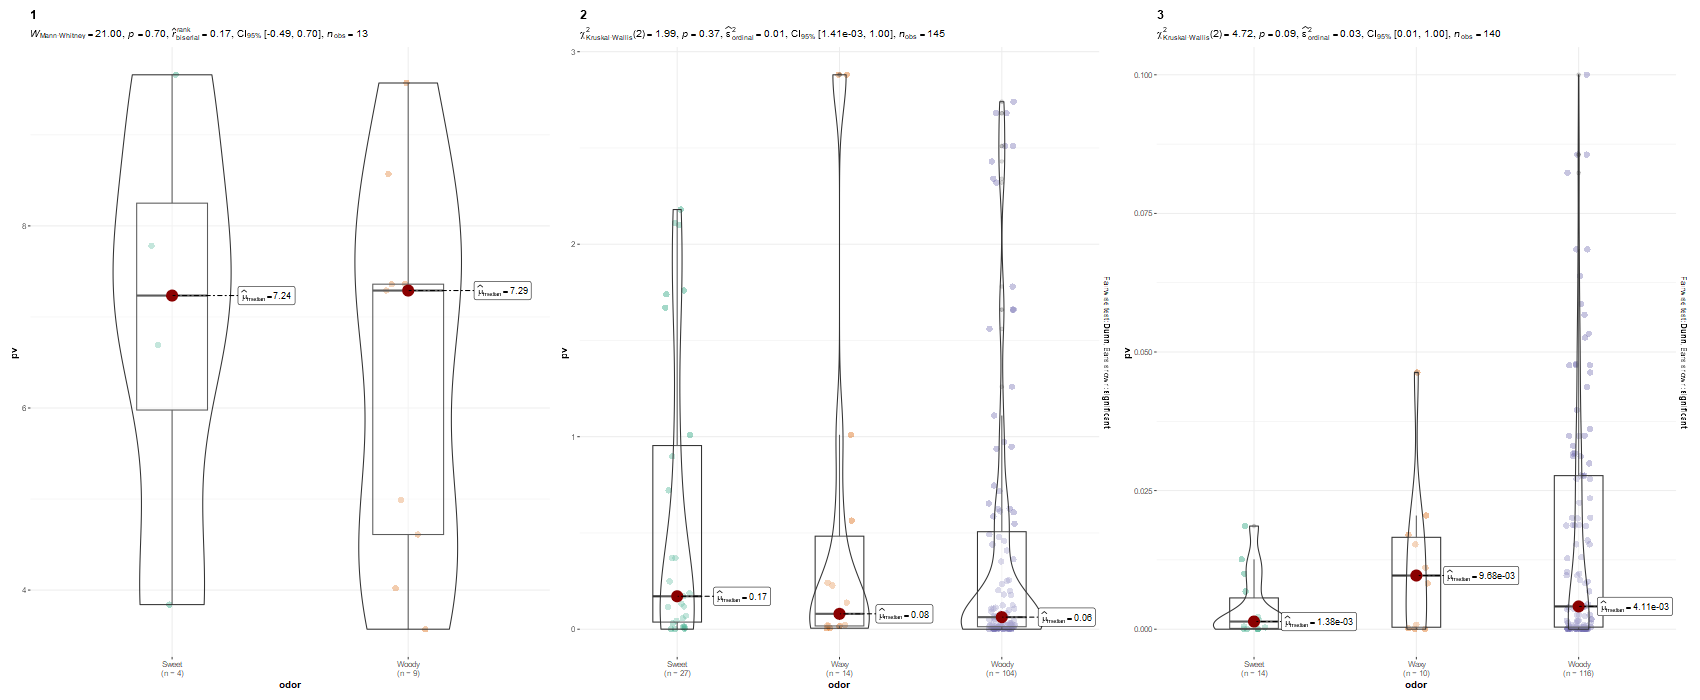

In [156]:
%%R -w 1700 -h 700 --type=cairo
grouped_ggbetweenstats(data = r_pca_odor_clus, x = odor, y = pv,
                        grouping.var = clus, type = "nonparametric",
                    results.subtitle = T, message = T, var.equal = F, p.adjust.method = "bonferroni",
                    ggsignif.args = list(textsize = 15, tip_length = 0.01)) +
  theme(text = element_text(size = 10), plot.subtitle = element_text(size =10))

# Analisis Ancova

La idea es ver si existen diferencias en los valores de pv entre los clusters o grupos olfativos teniendo en cuenta o controlando el peso molecular

In [122]:
%%R
# valores atípicos
head(r_pca_odor_clus,2)

                 odor pv  MolMR       MW MolLogP TPSA clus
Linalyl acetate Woody  0 59.033 196.1463  3.2406 26.3    3
Hexyl acetate   Woody  0 40.775 144.1150  2.1298 26.3    2


In [161]:
%%R -w 1300 -h 500 --type=cairo
anco_clus <- ggscatter(r_pca_odor_clus, x = 'MW', y = 'pv', color= 'clus', add = c('reg.line'), size = 4, title = 'By cluster',
            shape = 'odor', palette = "jco")+
            stat_cor(aes(color =clus))

In [162]:
%%R -w 1300 -h 500 --type=cairo
anco_odor <- ggscatter(r_pca_odor_clus, x = 'MW', y = 'pv', color= 'odor', add = 'reg.line', size = 4, title = 'By odor',
        shape = 'odor',palette = "jco")+
            stat_cor(aes(color = odor))

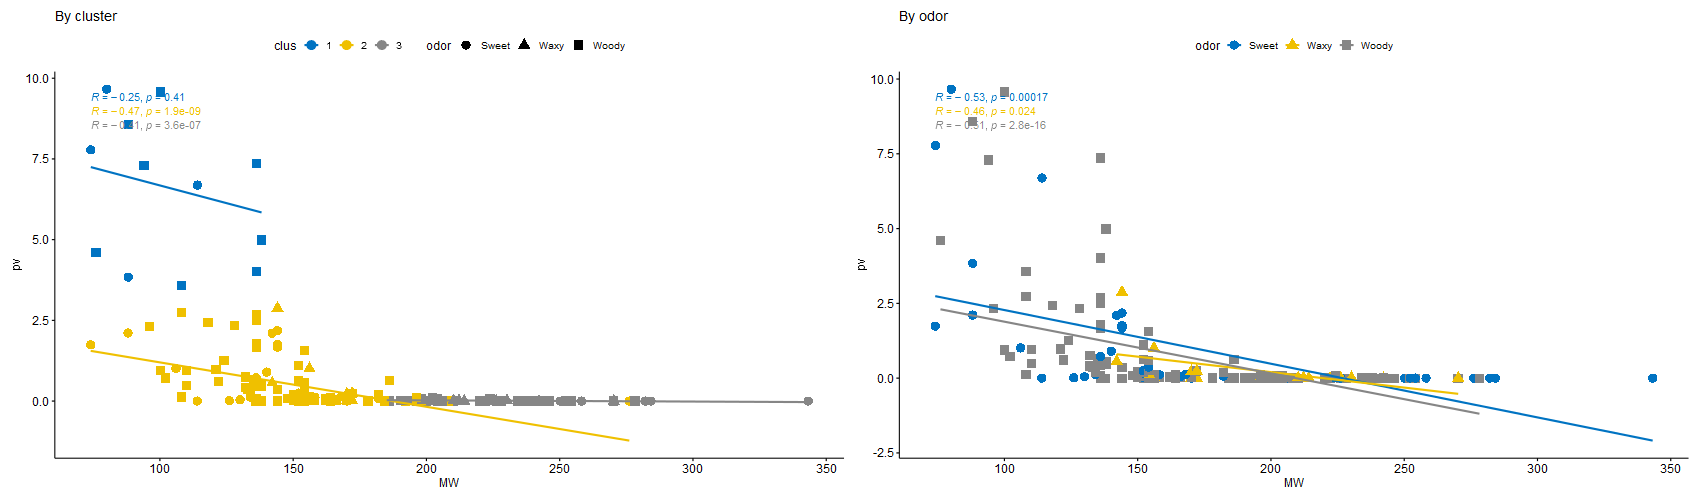

In [163]:
%%R -w 1700 -h 500 --type=cairo
anco_clus| anco_odor

In [124]:
%%R
#Verificar los supuestos: homogeneidad de las pendientes de regresion
# No deberíamos encontrar una interacion entre factor y covariable
model1 <- lm(pv ~ MW*clus, data = r_pca_odor_clus)
anova_test(model1)

ANOVA Table (type II tests)

   Effect DFn DFd       F        p p<.05   ges
1      MW   1 292  32.823 2.51e-08     * 0.101
2    clus   2 292 436.757 1.72e-88     * 0.749
3 MW:clus   2 292  11.423 1.67e-05     * 0.073


In [125]:
%%R
#Verificar los supuestos: homogeneidad de las pendientes de regresion
# No deberíamos encontrar una interacion entre factor y covariable
model2 <- lm(pv ~ MW*odor, data = r_pca_odor_clus)
anova_test(model2)

ANOVA Table (type II tests)

   Effect DFn DFd       F        p p<.05   ges
1      MW   1 292 103.382 5.46e-21     * 0.261
2    odor   2 292   1.429 2.41e-01       0.010
3 MW:odor   2 292   0.469 6.26e-01       0.003


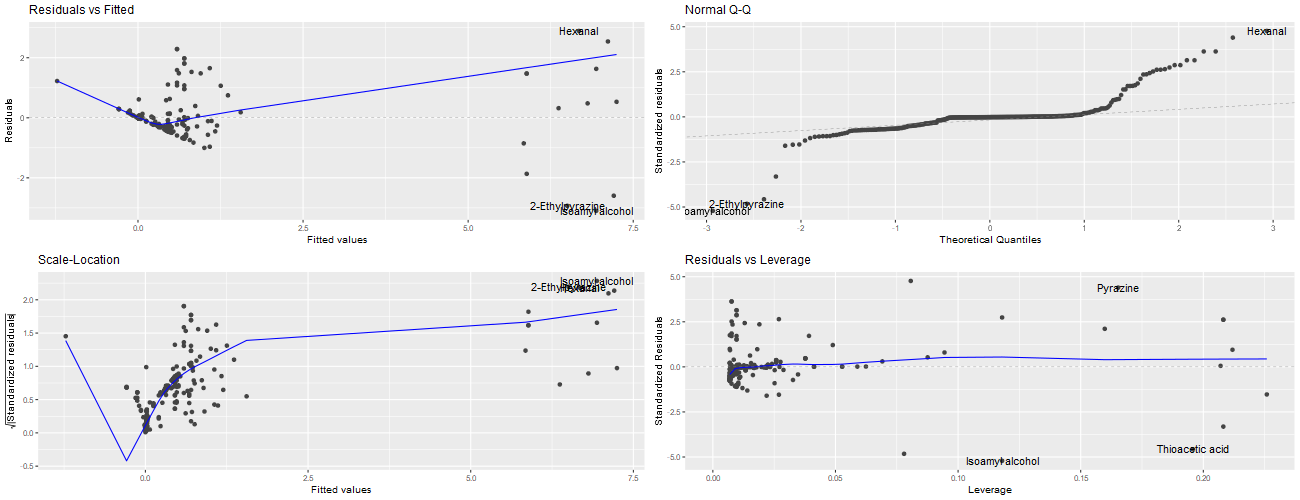

In [126]:
%%R -w 1300 -h 500 --type=cairo
model3 <- lm(pv ~ MW*clus, data = r_pca_odor_clus)
library(ggfortify)
autoplot(model3) + theme(text = element_text(size = 10))

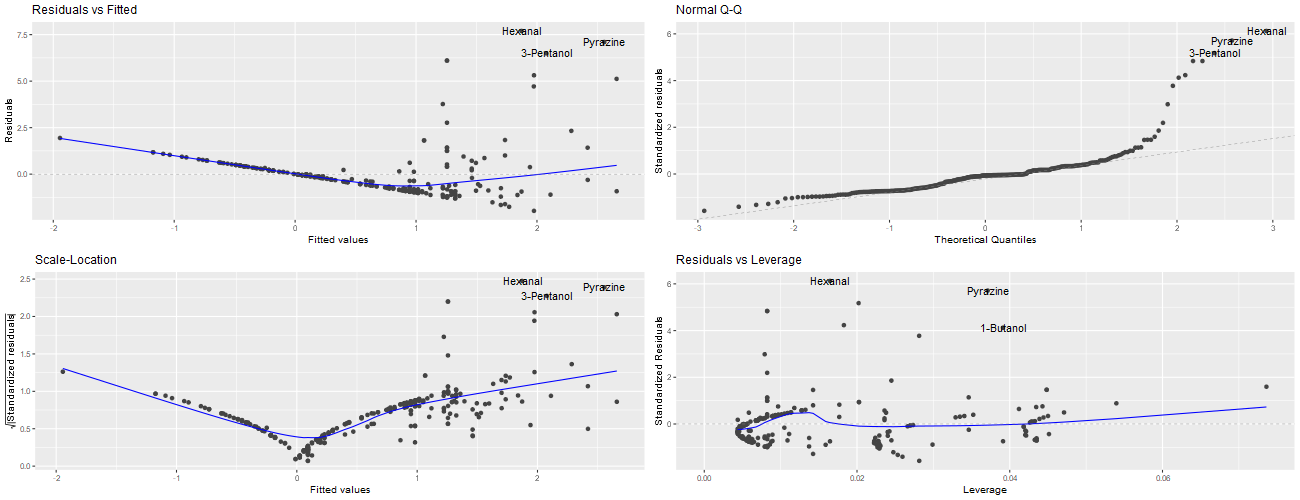

In [127]:
%%R -w 1300 -h 500 --type=cairo
model4 <- lm(pv ~ MW+odor, data = r_pca_odor_clus)
library(ggfortify)
autoplot(model4) + theme(text = element_text(size = 10))

In [128]:
%%R
# Ajuste del modelo con cluster
r_pca_odor_clus %>%
    anova_test(pv ~ MW*clus)

ANOVA Table (type II tests)

   Effect DFn DFd       F        p p<.05   ges
1      MW   1 292  32.823 2.51e-08     * 0.101
2    clus   2 292 436.757 1.72e-88     * 0.749
3 MW:clus   2 292  11.423 1.67e-05     * 0.073


In [129]:
%%R
# Ajuste del modelo con familia odor
r_pca_odor_clus %>%
    anova_test(pv ~ MW+odor)

ANOVA Table (type II tests)

  Effect DFn DFd       F        p p<.05   ges
1     MW   1 294 103.757 4.55e-21     * 0.261
2   odor   2 294   1.434 2.40e-01       0.010


Si existe una diferencia significativa en el valor de la pv controlando el WM


In [130]:
%%R
# pRUEBAS POST HOC para odor
library(emmeans)
pwc <- r_pca_odor_clus %>%
    emmeans_test(pv ~ odor, covariate = MW, p.adjust.method = 'bonferroni')
pwc

# A tibble: 3 x 9
  term    .y.   group1 group2    df statistic     p p.adj p.adj.signif
* <chr>   <chr> <chr>  <chr>  <dbl>     <dbl> <dbl> <dbl> <chr>       
1 MW*odor pv    Sweet  Waxy     294     1.23  0.221 0.662 ns          
2 MW*odor pv    Sweet  Woody    294     1.65  0.101 0.303 ns          
3 MW*odor pv    Waxy   Woody    294    -0.195 0.846 1     ns          


In [131]:
%%R
# pRUEBAS POST HOC para cluster
library(emmeans)
pwc1 <- r_pca_odor_clus %>%
    emmeans_test(pv ~ clus, covariate = MW, p.adjust.method = 'bonferroni')
pwc1

# A tibble: 3 x 9
  term    .y.   group1 group2    df statistic        p    p.adj p.adj.signif
* <chr>   <chr> <chr>  <chr>  <dbl>     <dbl>    <dbl>    <dbl> <chr>       
1 MW*clus pv    1      2        294    28.0   5.72e-85 1.72e-84 ****        
2 MW*clus pv    1      3        294    21.7   4.47e-63 1.34e-62 ****        
3 MW*clus pv    2      3        294    -0.796 4.27e- 1 1   e+ 0 ns          


In [132]:
 %%R
# Obtener medias ajustadas
get_emmeans(pwc1)

# A tibble: 3 x 8
     MW clus  emmean     se    df conf.low conf.high method      
  <dbl> <fct>  <dbl>  <dbl> <dbl>    <dbl>     <dbl> <chr>       
1  182. 1      5.92  0.216    294   5.49       6.34  Emmeans test
2  182. 2      0.228 0.0702   294   0.0897     0.366 Emmeans test
3  182. 3      0.329 0.0792   294   0.173      0.485 Emmeans test


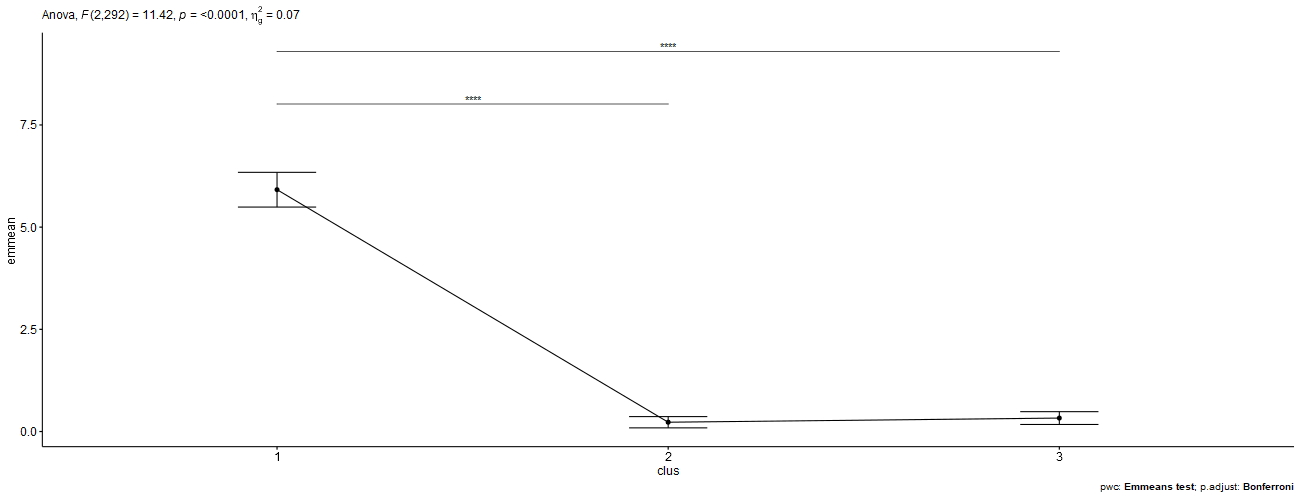

In [164]:
%%R -w 1300 -h 500 --type=cairo

res_anova_clus = r_pca_odor_clus %>%
    anova_test(pv ~ MW*clus)

pwc11 <- pwc1 %>% add_xy_position (x="clus", fun="mean_se")
 ggline(get_emmeans(pwc11), x = "clus", y = "emmean") +
    geom_errorbar(aes(ymin=  conf.low, ymax = conf.high), width = 0.2) +
    stat_pvalue_manual(pwc11, hide.ns=TRUE, tip.length= FALSE) +
   labs(subtitle = get_test_label(res_anova_clus, detailed = T),
        caption = get_pwc_label(pwc11))

In [134]:
%%R -w 1300 -h 500 --type=cairo

r_pca_odor_clus %>%
    anova_test(pv ~ MW+odor)

ANOVA Table (type II tests)

  Effect DFn DFd       F        p p<.05   ges
1     MW   1 294 103.757 4.55e-21     * 0.261
2   odor   2 294   1.434 2.40e-01       0.010


In [135]:
%%R -w 1300 -h 500 --type=cairo

r_pca_odor_clus %>%
    anova_test(pv ~ MW*clus)

ANOVA Table (type II tests)

   Effect DFn DFd       F        p p<.05   ges
1      MW   1 292  32.823 2.51e-08     * 0.101
2    clus   2 292 436.757 1.72e-88     * 0.749
3 MW:clus   2 292  11.423 1.67e-05     * 0.073


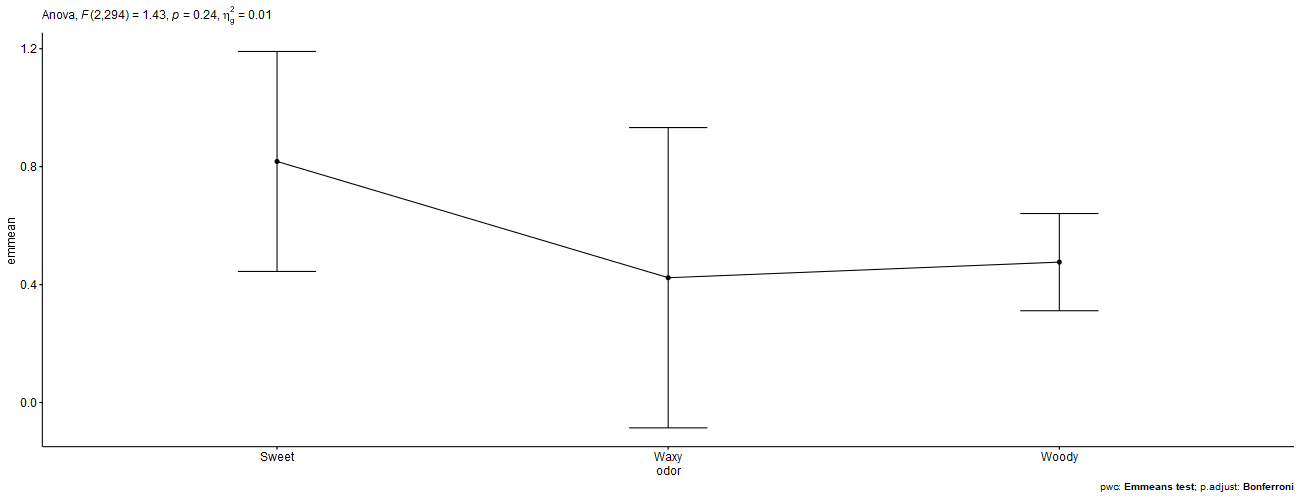

In [165]:
%%R -w 1300 -h 500 --type=cairo

res_anova_odor = r_pca_odor_clus %>%
    anova_test(pv ~ MW+odor)

pwc22 <- pwc %>% add_xy_position (x="odor", fun="mean_se")
 ggline(get_emmeans(pwc22), x = "odor", y = "emmean") +
    geom_errorbar(aes(ymin=  conf.low, ymax = conf.high), width = 0.2) +
    stat_pvalue_manual(pwc22, hide.ns=TRUE, tip.length= FALSE) +
   labs(subtitle = get_test_label(res_anova_odor, detailed = T),
        caption = get_pwc_label(pwc22))

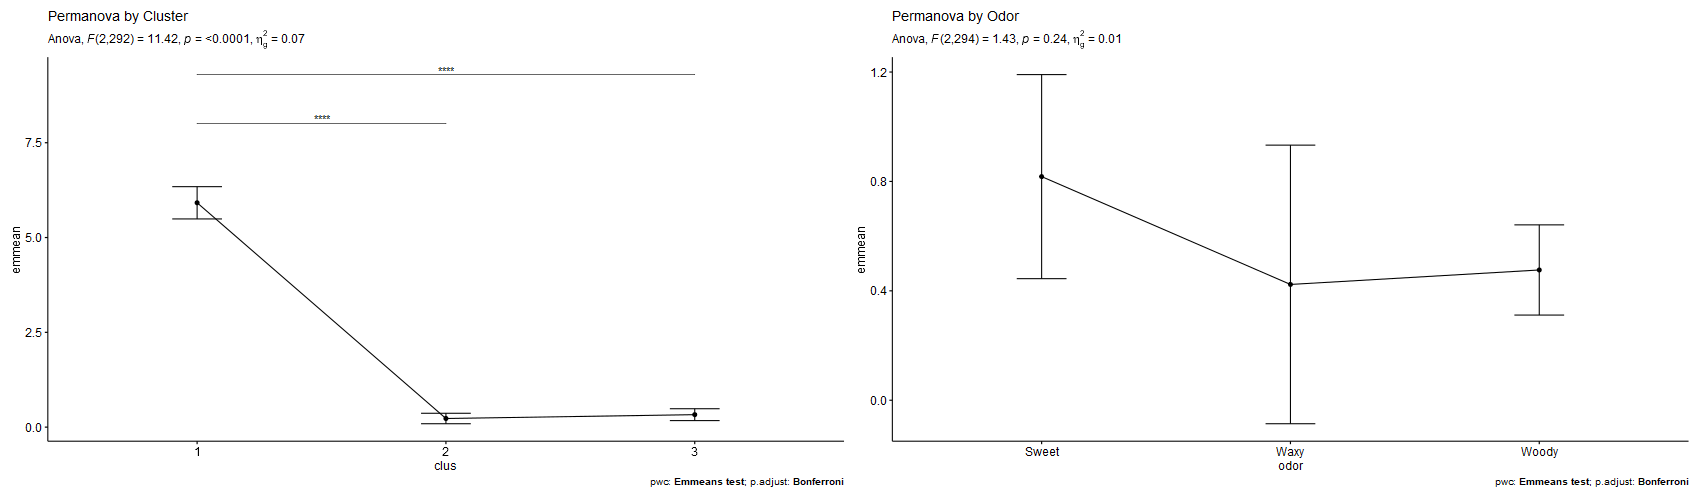

In [169]:
%%R -w 1700 -h 500 --type=cairo

res_anova_clus = r_pca_odor_clus %>%
    anova_test(pv ~ MW*clus)

pwc11 <- pwc1 %>% add_xy_position (x="clus", fun="mean_se")
Perma_clus <-  ggline(get_emmeans(pwc11), x = "clus", y = "emmean", title='Permanova by Cluster') +
    geom_errorbar(aes(ymin=  conf.low, ymax = conf.high), width = 0.2) +
    stat_pvalue_manual(pwc11, hide.ns=TRUE, tip.length= FALSE) +
   labs(subtitle = get_test_label(res_anova_clus, detailed = T),
        caption = get_pwc_label(pwc11))

res_anova_odor = r_pca_odor_clus %>%
    anova_test(pv ~ MW+odor)

pwc22 <- pwc %>% add_xy_position (x="odor", fun="mean_se")
Perma_odor <-  ggline(get_emmeans(pwc22), x = "odor", y = "emmean", title='Permanova by Odor') +
    geom_errorbar(aes(ymin=  conf.low, ymax = conf.high), width = 0.2) +
    stat_pvalue_manual(pwc22, hide.ns=TRUE, tip.length= FALSE) +
   labs(subtitle = get_test_label(res_anova_odor, detailed = T),
        caption = get_pwc_label(pwc22))

Perma_clus|Perma_odor

In [ ]:
%%R 
#data_pca <- r_data_odor[,c(3,5,7:17)]
data_pca <- r_data_odor[,c(3,5:9)]
row.names(data_pca) <- r_data_odor$Name
r_pca_odor <- PCA(data_pca, scale.unit = T, graph = F, quali.sup = 1)
get_eigenvalue(r_pca_odor)

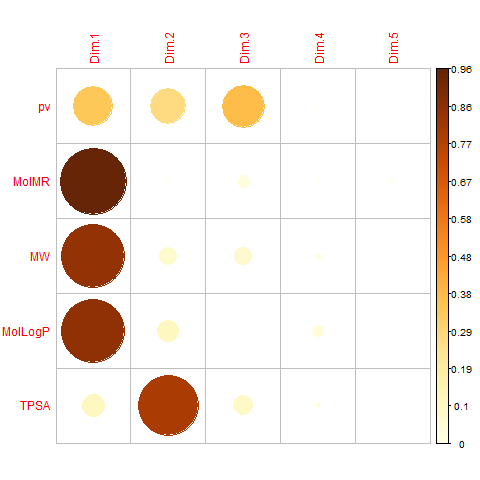

In [139]:
%%R
library("corrplot")
var <- get_pca_var(r_pca_odor)
corrplot(var$cos2, is.corr=FALSE)

# Convirtiendo data frame de R a python

In [170]:
%%R -i raw_dara_odor
r_raw_dara_odor <- as.data.frame(raw_dara_odor)

In [ ]:
%%R -o data_R_pd
pca_odor <- prcomp(r_data_odor[,c(5:9)], scale = T)
scores = as.data.frame(pca_odor$x)
data_R_pd <- cbind(r_raw_dara_odor, clus = r_pca_odor_clus$clus, scores)
head(data_R_pd)

In [149]:
from rpy2.robjects import pandas2ri
data_r_python = pandas2ri.PandasDataFrame(data_R_pd)
data_r_python = pd.DataFrame(data_r_python).reset_index(drop=True)
print('Columns', data_r_python.columns, '\n')
print('NULL VALUES:', data_r_python.columns.isnull().sum())
data_r_python.head()

Columns Index(['CAS', 'Name', 'odor', 'smiles', 'pv', 'odor_categorical', 'MolMR',
       'MW', 'MolLogP', 'TPSA', 'CSP3', 'Part_charg', 'n_Atoms', 'n_car_acid',
       'n_ester', 'n_benzene', 'n_eter', 'n_ketone', 'n_Aldehyde', 'clus',
       'PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
      dtype='object') 

NULL VALUES: 0


,CAS,Name,odor,smiles,pv,odor_categorical,MolMR,MW,MolLogP,TPSA,CSP3,Part_charg,n_Atoms,n_car_acid,n_ester,n_benzene,n_eter,n_ketone,n_Aldehyde,clus,PC1,PC2,PC3,PC4,PC5
0,115-95-7,Linalyl acetate,Woody,CC(C)=CCCC(C)(OC(C)=O)C=C,0.000000e+00,Wo,59.0330,196.146330,3.2406,26.30,0.583333,-0.044213,14,1,1,0,1,0,1,3,-0.397153,0.600388,0.072206,0.062186,0.028681
1,142-92-7,Hexyl acetate,Woody,CCCCCCOC(C)=O,0.000000e+00,Wo,40.7750,144.115030,2.1298,26.30,0.875000,-0.065382,10,1,1,0,1,0,1,2,1.415015,0.534227,-0.697352,0.114006,-0.082609
2,67634-12-2,Methyl 2-[[[4-(4-hydroxy-4-methylpentyl)-3-,Sweet,COC(=O)c1ccccc1N=CC2CCC(=CC2)CCCC(C)(C)O,7.790000e-10,SW,101.5063,343.214744,4.8432,58.89,0.523810,0.080954,25,1,1,1,1,0,1,3,-4.056243,3.026988,2.936703,0.038191,0.247921
3,105-95-3,"1,4-Dioxacycloheptadecane-5,17-dione",Woody,O=C1CCCCCCCCCCCC(=O)OCCO1,4.380000e-07,Wo,72.7050,270.183109,3.3775,52.60,0.866667,-0.252298,19,2,2,0,2,0,2,3,-1.514111,2.535601,1.629997,0.020980,-0.126744
4,10402-33-2,Eugenyl phenylacetate,Sweet,COc1cc(CC=C)ccc1OC(=O)Cc2ccccc2,2.940000e-06,SW,82.6760,282.125594,3.5718,35.53,0.166667,0.077718,21,1,1,2,2,0,1,3,-2.360311,1.588415,1.421115,-0.619336,0.143470


# Intento power BI

In [150]:
from powerbiclient import Report, models, get_dataset_config, QuickVisualize
from powerbiclient.authentication import DeviceCodeLoginAuthentication, InteractiveLoginAuthentication

In [151]:
auth = DeviceCodeLoginAuthentication()

Performing device flow authentication. Please follow the instructions below.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code FLQA4MJN8 to authenticate.

Device flow authentication successfully completed.
You are now logged in .

The result should be passed only to trusted code in your notebook.


In [ ]:
data_r_python['odor'] = data_r_python['odor'].astype(str)
data_r_python['clus'] = data_r_python['clus'].astype(int)
data_r_python.dtypes

In [ ]:
PBI_visualize = QuickVisualize(get_dataset_config(data_r_python), auth = auth)

In [159]:
PBI_visualize

QuickVisualize()

# anova 2 mixto

### evaluación de los supuestos



In [ ]:
%%R
rownames(r_pca_odor_clus)

In [167]:
%%R
r_pca_odor_clus_copy <- r_pca_odor_clus
r_pca_odor_clus_copy$ID <- seq.int(nrow(r_pca_odor_clus_copy))
r_pca_odor_clus_copy$Name <- rownames(r_pca_odor_clus_copy)
head(r_pca_odor_clus_copy,2)

                 odor pv  MolMR       MW MolLogP TPSA clus ID            Name
Linalyl acetate Woody  0 59.033 196.1463  3.2406 26.3    3  1 Linalyl acetate
Hexyl acetate   Woody  0 40.775 144.1150  2.1298 26.3    2  2   Hexyl acetate


In [168]:
%%R
r_pca_odor_clus_copy_long <- r_pca_odor_clus_copy %>% 
        gather(key = 'test', value = 'values', 
        pv,MolMR,MW,MolLogP,TPSA) %>%
        convert_as_factor(ID,test)
head(r_pca_odor_clus_long,2)

   odor clus ID            Name test values
1 Woody    2  1 Linalyl acetate   pv      0
2 Woody    1  2   Hexyl acetate   pv      0


In [169]:
%%R
r_pca_odor_clus_long %>%
    group_by(test, clus) %>%
    get_summary_stats(values, type = 'mean_sd')

# A tibble: 10 x 6
   clus  test    variable     n    mean     sd
   <fct> <fct>   <fct>    <dbl>   <dbl>  <dbl>
 1 1     MolLogP values     155   2.17   0.764
 2 2     MolLogP values     155   4.02   0.702
 3 1     MolMR   values     155  43.2    8.02 
 4 2     MolMR   values     155  67.0    7.16 
 5 1     MW      values     155 146.    26.7  
 6 2     MW      values     155 218.    25.4  
 7 1     pv      values     155   1.03   2.03 
 8 2     pv      values     155   0.021  0.055
 9 1     TPSA    values     155  22.9   13.7  
10 2     TPSA    values     155  17.7   13.9  


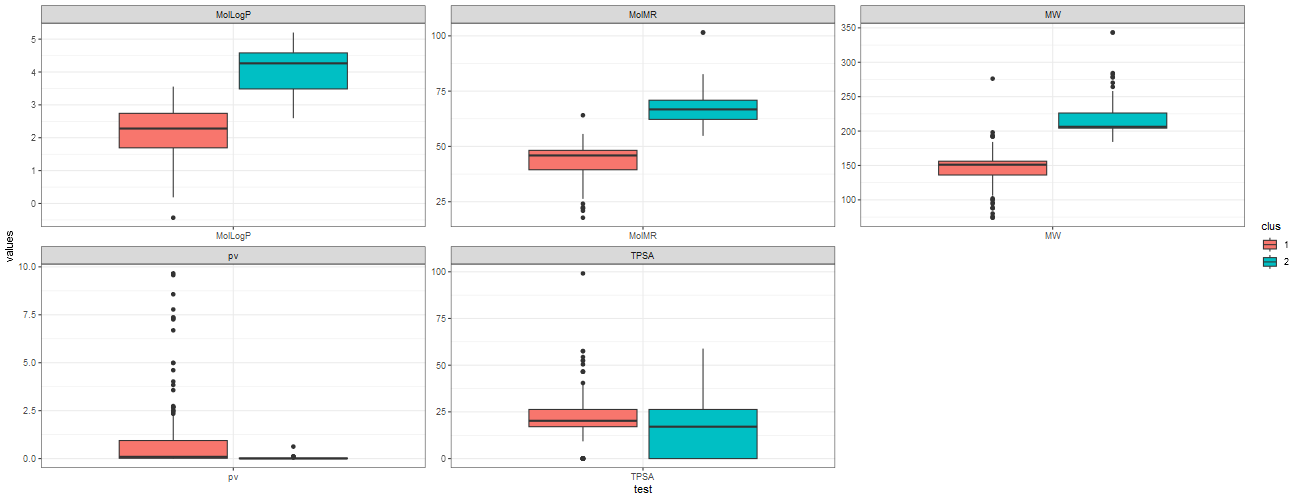

In [170]:
%%R -w 1300 -h 500 --type=cairo
ggplot(data = r_pca_odor_clus_long, aes(x=test, y = values)) +
    geom_boxplot(aes(fill = clus), widh = 0.8) + theme_bw() +
    facet_wrap(~test, ncol=3, scales="free")

In [ ]:
%%R
# Valores atípicos

i1 <- r_pca_odor_clus_long %>%
    group_by(test, clus) %>%
    identify_outliers(values)
print(i1,n=100)

In [172]:
%%R
# Normalidad
r_pca_odor_clus_long %>%
    group_by(test, clus) %>%
    shapiro_test(values)

# A tibble: 10 x 5
   clus  test    variable statistic        p
   <fct> <fct>   <chr>        <dbl>    <dbl>
 1 1     MolLogP values       0.969 1.45e- 3
 2 2     MolLogP values       0.952 3.80e- 5
 3 1     MolMR   values       0.919 1.16e- 7
 4 2     MolMR   values       0.904 1.38e- 8
 5 1     MW      values       0.929 6.12e- 7
 6 2     MW      values       0.819 1.43e-12
 7 1     pv      values       0.569 1.70e-19
 8 2     pv      values       0.325 1.01e-23
 9 1     TPSA    values       0.877 4.93e-10
10 2     TPSA    values       0.894 4.23e- 9


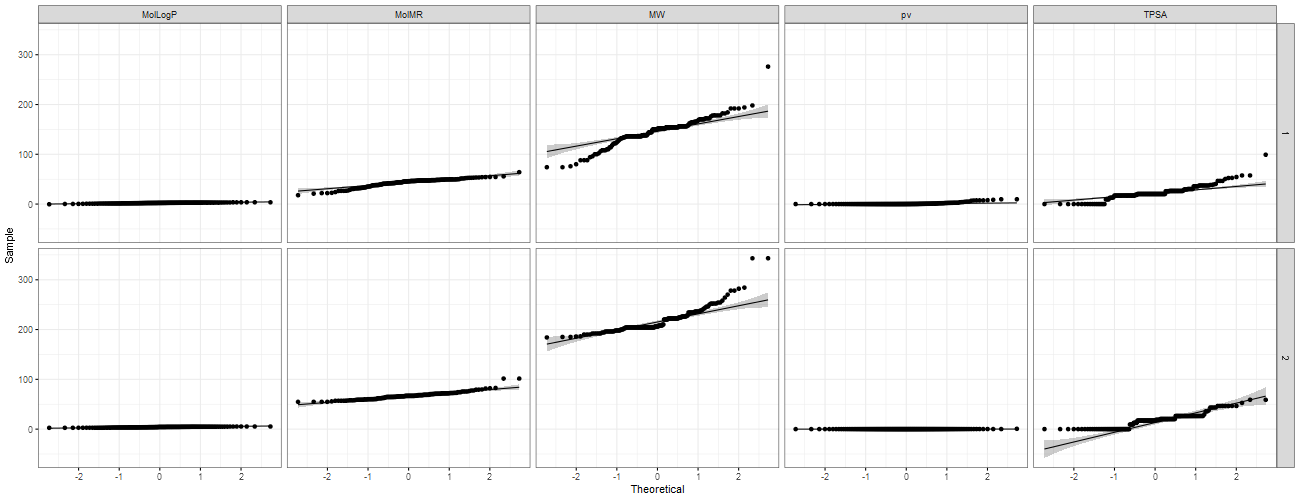

In [173]:
%%R -w 1300 -h 500 --type=cairo
ggqqplot(r_pca_odor_clus_long, 'values', ggtheme = theme_bw()) +
    facet_grid(clus~test)

In [171]:
%%R
# Homogeneidad de varianza 
r_pca_odor_clus_long %>%
    group_by(test)%>%
    levene_test(values ~ clus) 

# A tibble: 5 x 5
  test      df1   df2 statistic             p
  <fct>   <int> <int>     <dbl>         <dbl>
1 MolLogP     1   308    0.0181 0.893        
2 MolMR       1   308    1.73   0.190        
3 MW          1   308    0.301  0.584        
4 pv          1   308   38.4    0.00000000184
5 TPSA        1   308    1.76   0.186        


In [464]:
%%R
# Homogeneidad de  covarianza
box_m(r_pca_odor_clus_long[, 'values', drop = F], r_pca_odor_clus_long$clus)

# A tibble: 1 x 4
  statistic  p.value parameter method                                           
      <dbl>    <dbl>     <dbl> <chr>                                            
1      122. 2.65e-28         1 Box's M-test for Homogeneity of Covariance Matri~


Ajustar modelo

In [ ]:
%%R
res.aov <- anova_test(data = r_pca_odor_clus_long, dv = values, wid = ID, between = clus, within = test)
get_anova_table(res.aov) #realiza una correccion automatica por no cumplimineto del suepuesto de homogeneidad de covarianza

In [ ]:
%%R
# Pruebas post-hoc para una interaccion significativa
i2<- r_pca_odor_clus_long %>%
    group_by(clus) %>%
    pairwise_t_test(values ~ test, paired = T, p.adjust.method = 'holm') %>%
    filter(p.adj < 0.05)

print(i2,n=100)

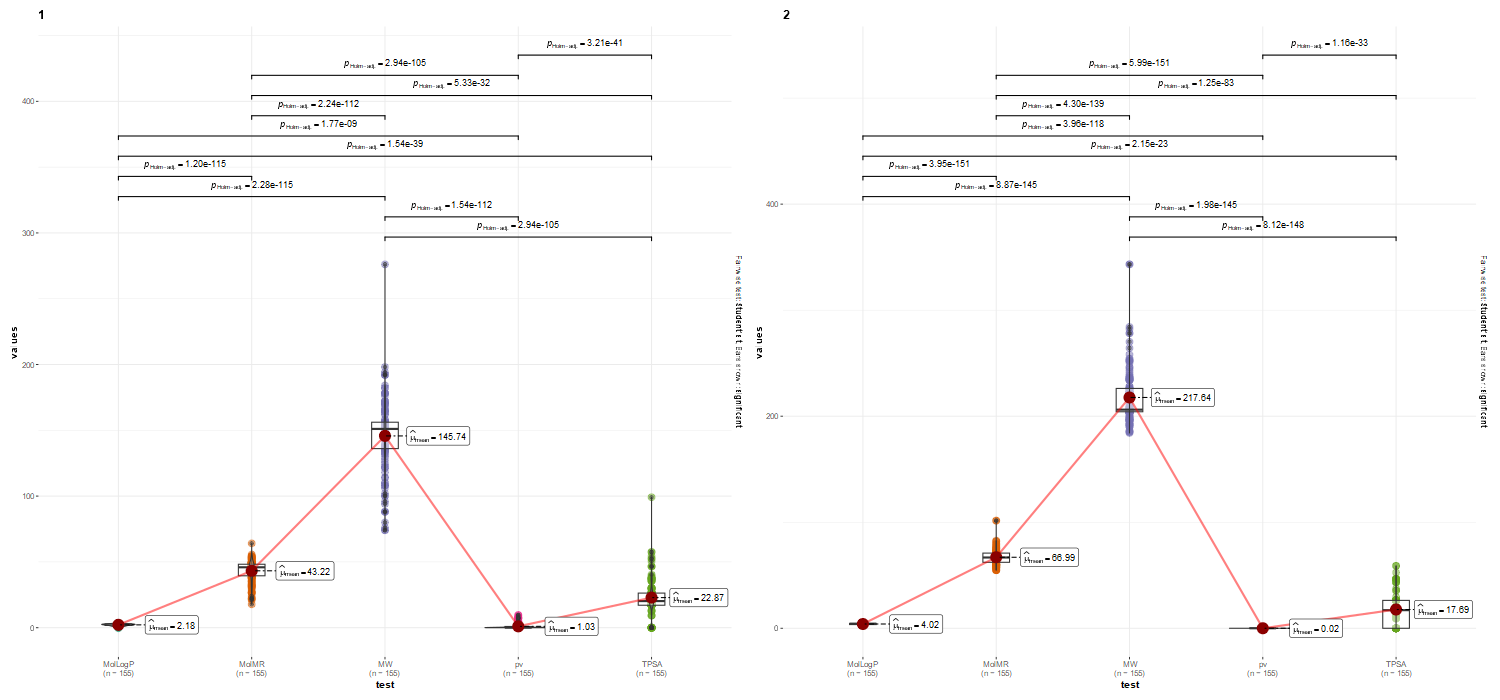

In [182]:
%%R -w 1500 -h 700 --type=cairo
grouped_ggwithinstats(data = r_pca_odor_clus_long, x = test, y = values, grouping.var = clus,
                results.subtitle = F, messages = F, var.equal = F, p.adjust.method = 'holm')

In [61]:
%%R
head(r_pca_odor_clus_long,2)

   odor clus ID            Name test values
1 Woody    2  1 Linalyl acetate   pv      0
2 Woody    1  2   Hexyl acetate   pv      0
